사용 가능한 한글 폰트: ['NanumSquare', 'NanumGothicCoding', 'NanumBarunGothic', 'NanumGothic', 'NanumSquareRound', 'NanumMyeongjo']
NanumGothic 폰트 발견: /usr/share/fonts/truetype/nanum/NanumGothic.ttf
✅ 한글 폰트 설정 완료: NanumGothic
현재 설정된 폰트: ['NanumGothic']


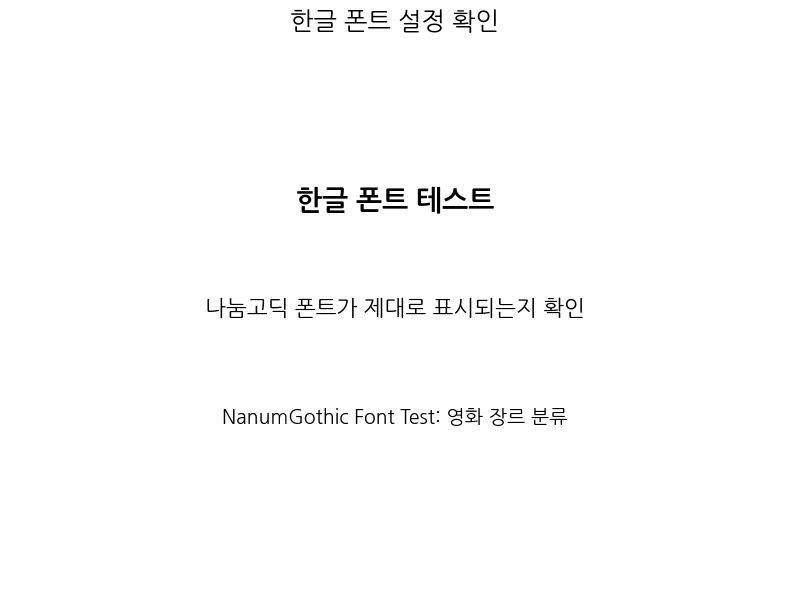

matplotlib 한글 폰트 설정이 완료되었습니다.


In [1]:
# matplotlib에서 한글 폰트 설정 (NanumGothic)
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import os

# matplotlib 폰트 캐시 새로고침
fm._load_fontmanager(try_read_cache=False)

# 시스템에서 사용 가능한 한글 폰트 찾기
korean_fonts = []
for font in fm.fontManager.ttflist:
    if any(keyword in font.name for keyword in ['Korean', 'Nanum', 'Malgun', 'Dotum', 'Gulim']):
        korean_fonts.append(font.name)

# 중복 제거
korean_fonts = list(set(korean_fonts))
print("사용 가능한 한글 폰트:", korean_fonts)

# NanumGothic 폰트 경로 확인
nanum_paths = [
    '/usr/share/fonts/truetype/nanum/NanumGothic.ttf',
    '/usr/share/fonts/truetype/nanum/NanumGothicBold.ttf',
    '/System/Library/Fonts/NanumGothic.ttc',
    '/Library/Fonts/NanumGothic.ttc'
]

nanum_available = False
for path in nanum_paths:
    if os.path.exists(path):
        print(f"NanumGothic 폰트 발견: {path}")
        nanum_available = True
        break

# 한글 폰트 설정 (우선순위별로 시도)
font_candidates = ['NanumGothic', 'NanumGothicOTF', 'Nanum Gothic', 'Malgun Gothic', 'DejaVu Sans']

font_set = False
for font_name in font_candidates:
    try:
        plt.rcParams['font.family'] = font_name
        # 테스트용 간단한 플롯으로 폰트 확인
        fig, ax = plt.subplots(figsize=(6, 4))
        ax.text(0.5, 0.5, '한글 테스트: 나눔고딕', fontsize=16, ha='center', va='center')
        ax.set_title('한글 폰트 테스트')
        plt.close(fig)  # 실제로 표시하지 않고 닫기
        print(f"✅ 한글 폰트 설정 완료: {font_name}")
        font_set = True
        break
    except Exception as e:
        print(f"❌ {font_name} 설정 실패: {e}")
        continue

if not font_set:
    # 기본 폰트로 설정하고 마이너스 기호 문제 해결
    plt.rcParams['font.family'] = 'DejaVu Sans'
    print("⚠️ 한글 폰트를 찾을 수 없어 기본 폰트를 사용합니다.")

# 마이너스 기호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

# 현재 설정된 폰트 확인
current_font = plt.rcParams['font.family']
print(f"현재 설정된 폰트: {current_font}")

# 한글 폰트 테스트
fig, ax = plt.subplots(figsize=(8, 6))
ax.text(0.5, 0.7, '한글 폰트 테스트', fontsize=20, ha='center', va='center', weight='bold')
ax.text(0.5, 0.5, '나눔고딕 폰트가 제대로 표시되는지 확인', fontsize=16, ha='center', va='center')
ax.text(0.5, 0.3, 'NanumGothic Font Test: 영화 장르 분류', fontsize=14, ha='center', va='center')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_title('한글 폰트 설정 확인', fontsize=18)
ax.axis('off')
plt.tight_layout()
plt.show()

print("matplotlib 한글 폰트 설정이 완료되었습니다.")

# 멀티모달 융합 기반 영화 장르 예측 모델 구현

이 노트북은 MM-IMDb 데이터셋을 활용하여 다양한 멀티모달 융합 기법으로 영화 장르를 예측하는 모델을 구현하고 성능을 비교 평가합니다.

## 주요 구현 내용
- 데이터 로딩 및 전처리: MM-IMDb 데이터셋 로딩, 이미지/텍스트 전처리
- 특징 추출 모델: ResNet50, ViT, BERT, RoBERTa
- 융합 전략: Early Fusion, Late Fusion, Attention Fusion, Cross-Attention Fusion
- 평가 지표: Accuracy, Precision, Recall, F1-score, ROC-AUC, mAP

## 1. 필요 라이브러리 임포트

In [2]:
# 기본 라이브러리
import os
import json
import random
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# 이미지 처리
import cv2
from PIL import Image

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

# 딥러닝 모델
import timm  # Vision Transformer용
from transformers import BertTokenizer, BertModel, RobertaTokenizer, RobertaModel

# 평가 지표
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, average_precision_score, confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix, classification_report

# 시각화
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

# 기타 유틸리티
import warnings
warnings.filterwarnings('ignore')

# 재현성 설정
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# GPU 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## 2. 데이터 로딩 및 전처리

In [3]:
# 테스트 모드 설정 (빠른 실험을 위한 설정)
TEST_MODE = False # True: 데이터 일부만 사용, False: 전체 데이터 사용
TEST_DATA_RATIO = 0.01  # 테스트 모드시 사용할 데이터 비율

# 데이터 경로 설정
DATA_ROOT = "/home/mingky/workspace/mmimdb_test/data/mmimdb"
DATASET_PATH = os.path.join(DATA_ROOT, "dataset")
SPLIT_PATH = os.path.join(DATA_ROOT, "split.json")

# 분할 정보 로드
with open(SPLIT_PATH, 'r') as f:
    splits = json.load(f)

print("\n" + "="*80)
print(" 논문 A(gmu-mmimdb)와 동일한 방식으로 데이터셋 구성")
print(" GitHub: https://github.com/johnarevalo/gmu-mmimdb")
print("="*80)

# 1단계: 모든 영화 데이터 로드 및 장르 정보 수집
all_movie_ids = list(set(splits['train'] + splits.get('val', splits.get('dev', [])) + splits['test']))

print(f"\n전체 데이터셋 로드 중... (총 {len(all_movie_ids)}개 샘플)")

movies_data = []
all_genres_set = set()

for movie_id in tqdm(all_movie_ids, desc="Loading movie data"):
    json_path = os.path.join(DATASET_PATH, f"{movie_id}.json")
    if os.path.exists(json_path):
        with open(json_path, 'r') as f:
            movie_data = json.load(f)
            genres = movie_data.get('genres', [])
            if genres:  # 장르가 있는 영화만 포함
                movies_data.append({
                    'id': movie_id,
                    'genres': genres
                })
                all_genres_set.update(genres)

print(f"유효한 샘플 수: {len(movies_data)}")
print(f"전체 장르 수: {len(all_genres_set)}")

# 2단계: 장르별 빈도 계산 및 상위 23개 선택 (논문 A와 동일)
from collections import Counter
genre_counts = Counter([g for m in movies_data for g in m['genres']])
print(f"\n장르별 샘플 수 (전체 {len(genre_counts)}개 장르):")
for genre, count in sorted(genre_counts.items(), key=lambda x: x[1]):
    print(f"  {genre:<20}: {count:>5} samples")

# 상위 23개 장르 선택
top_23_genres = [genre for genre, _ in genre_counts.most_common(23)]
SELECTED_GENRES = top_23_genres

print(f"\n📊 선택된 23개 장르 (논문 A와 동일, 빈도순):")
for i, genre in enumerate(SELECTED_GENRES, 1):
    print(f"  {i:2d}. {genre:<20}: {genre_counts[genre]:>5} samples")

excluded_genres = all_genres_set - set(SELECTED_GENRES)
print(f"\n❌ 제외된 장르 ({len(excluded_genres)}개):")
for genre in sorted(excluded_genres):
    print(f"  - {genre}: {genre_counts[genre]} samples")

# 3단계: Multi-label Binary Matrix 생성 (sklearn.preprocessing.MultiLabelBinarizer)
from sklearn.preprocessing import MultiLabelBinarizer
import math

# 선택된 23개 장르만 포함하는 샘플 필터링
valid_movies = []
for movie in movies_data:
    # 선택된 장르 중 하나라도 포함하면 유효
    if any(g in SELECTED_GENRES for g in movie['genres']):
        # 선택된 장르만 필터링
        filtered_genres = [g for g in movie['genres'] if g in SELECTED_GENRES]
        valid_movies.append({
            'id': movie['id'],
            'genres': filtered_genres
        })

print(f"\n선택된 23개 장르를 포함하는 샘플 수: {len(valid_movies)}")

# Multi-label binary matrix 생성
mlb = MultiLabelBinarizer(classes=SELECTED_GENRES)
Y = mlb.fit_transform([m['genres'] for m in valid_movies])
movie_ids = [m['id'] for m in valid_movies]

print(f"Multi-label matrix shape: {Y.shape}")
print(f"  - Samples: {Y.shape[0]}")
print(f"  - Classes: {Y.shape[1]}")

# 4단계: 논문 A의 Stratified Sampling 알고리즘 적용
# 출처: https://github.com/johnarevalo/gmu-mmimdb/blob/main/make_dataset.py#L84-L108
print("\n" + "="*80)
print("🎯 논문 A의 Stratified Sampling 알고리즘 적용")
print("   알고리즘: 각 장르별로 역순 처리, 샘플 단위 할당")
print("   분할 비율: Train 60%, Val 10%, Test 30%")
print("="*80)

# 설정
SEED = 42
train_size = 0.6
dev_size = 0.1  # val
test_size = 0.3

# 논문 A의 알고리즘 그대로 구현
B = np.copy(Y)  # 작업용 복사본
rng = np.random.RandomState(SEED)
train_idx, dev_idx, test_idx = [], [], []

# 장르 인덱스 (0~22)
labels = list(range(len(SELECTED_GENRES)))

# 논문 A: 장르별로 역순으로 처리 (labels[::-1])
for l in tqdm(labels[::-1], desc="Stratified sampling by genre"):
    # 해당 장르를 가진 샘플의 인덱스 (아직 할당되지 않은 것만)
    t = B[:, l].nonzero()[0]
    
    if len(t) == 0:
        continue
    
    # 랜덤 셔플
    t = rng.permutation(t)
    
    # 분할 크기 계산 (math.ceil 사용)
    n_test = int(math.ceil(len(t) * test_size))
    n_dev = int(math.ceil(len(t) * dev_size))
    n_train = len(t) - n_test - n_dev
    
    # 인덱스 할당
    test_idx.extend(t[:n_test])
    dev_idx.extend(t[n_test:n_test + n_dev])
    train_idx.extend(t[n_test + n_dev:])
    
    # 할당된 샘플은 0으로 마킹 (재사용 방지)
    B[t, :] = 0

# 인덱스를 실제 movie ID로 변환
train_ids = [movie_ids[i] for i in train_idx]
val_ids = [movie_ids[i] for i in dev_idx]
test_ids = [movie_ids[i] for i in test_idx]

print(f"\n✅ Stratified Sampling 완료 (논문 A 알고리즘):")
print(f"   Train set: {len(train_ids)} samples ({len(train_ids)/(len(train_ids)+len(val_ids)+len(test_ids))*100:.1f}%)")
print(f"   Val set:   {len(val_ids)} samples ({len(val_ids)/(len(train_ids)+len(val_ids)+len(test_ids))*100:.1f}%)")
print(f"   Test set:  {len(test_ids)} samples ({len(test_ids)/(len(train_ids)+len(val_ids)+len(test_ids))*100:.1f}%)")
print(f"   Total:     {len(train_ids)+len(val_ids)+len(test_ids)} samples")

# 중복 확인
train_set = set(train_ids)
val_set = set(val_ids)
test_set = set(test_ids)

overlap_train_val = train_set & val_set
overlap_train_test = train_set & test_set
overlap_val_test = val_set & test_set

print(f"\n✅ 중복 검사 (논문 A 방식):")
print(f"   Train-Val 중복: {len(overlap_train_val)} samples")
print(f"   Train-Test 중복: {len(overlap_train_test)} samples")
print(f"   Val-Test 중복: {len(overlap_val_test)} samples")

# 테스트 모드일 경우 데이터 일부만 사용
if TEST_MODE:
    import random
    random.seed(42)
    
    num_train = int(len(train_ids) * TEST_DATA_RATIO)
    num_val = int(len(val_ids) * TEST_DATA_RATIO)
    num_test = int(len(test_ids) * TEST_DATA_RATIO)
    
    train_ids = random.sample(train_ids, num_train)
    val_ids = random.sample(val_ids, num_val)
    test_ids = random.sample(test_ids, num_test)
    
    print(f"\n🧪 TEST MODE 활성화됨 (데이터의 {TEST_DATA_RATIO*100}%만 사용)")

print("="*80)


 논문 A(gmu-mmimdb)와 동일한 방식으로 데이터셋 구성
 GitHub: https://github.com/johnarevalo/gmu-mmimdb

전체 데이터셋 로드 중... (총 25959개 샘플)


Loading movie data:   0%|          | 0/25959 [00:00<?, ?it/s]

유효한 샘플 수: 25959
전체 장르 수: 27

장르별 샘플 수 (전체 27개 장르):
  Reality-TV          :     1 samples
  Talk-Show           :     2 samples
  Adult               :     4 samples
  News                :    64 samples
  Film-Noir           :   338 samples
  Short               :   471 samples
  Sport               :   634 samples
  Western             :   705 samples
  Musical             :   841 samples
  Animation           :   997 samples
  Music               :  1045 samples
  History             :  1143 samples
  War                 :  1335 samples
  Biography           :  1343 samples
  Family              :  1668 samples
  Fantasy             :  1933 samples
  Sci-Fi              :  1991 samples
  Mystery             :  2057 samples
  Documentary         :  2082 samples
  Horror              :  2703 samples
  Adventure           :  2710 samples
  Action              :  3550 samples
  Crime               :  3838 samples
  Thriller            :  5192 samples
  Romance             :  5364 samples

Stratified sampling by genre:   0%|          | 0/23 [00:00<?, ?it/s]


✅ Stratified Sampling 완료 (논문 A 알고리즘):
   Train set: 15552 samples (59.9%)
   Val set:   2608 samples (10.0%)
   Test set:  7799 samples (30.0%)
   Total:     25959 samples

✅ 중복 검사 (논문 A 방식):
   Train-Val 중복: 0 samples
   Train-Test 중복: 0 samples
   Val-Test 중복: 0 samples


In [4]:
# 논문 A Table 1 형식: Stratified Sampling 결과 - 장르별 분포 확인
print("\n" + "="*100)
print(" 논문 A (1702.01992v1) Table 1 형식: 데이터셋의 장르별 분포 (Stratified Sampling 결과)")
print(" 사용 장르: 23개 (논문 A와 동일)")
print("="*100 + "\n")

# 각 split별 장르 분포 계산 (선택된 23개 장르만)
def calculate_genre_distribution(movie_ids, dataset_path, selected_genres):
    """각 데이터셋의 장르별 샘플 수 계산 (선택된 장르만)"""
    genre_counts = {}
    
    for movie_id in movie_ids:
        json_path = os.path.join(dataset_path, f"{movie_id}.json")
        if os.path.exists(json_path):
            with open(json_path, 'r') as f:
                movie_data = json.load(f)
                all_genres = movie_data.get('genres', [])
                # 선택된 장르만 필터링
                genres = [g for g in all_genres if g in selected_genres]
                for genre in genres:
                    if genre not in genre_counts:
                        genre_counts[genre] = 0
                    genre_counts[genre] += 1
    
    return genre_counts

# 각 split에 대한 장르 분포 계산
print("장르별 샘플 수 계산 중...")
train_genre_dist = calculate_genre_distribution(train_ids, DATASET_PATH, SELECTED_GENRES)
val_genre_dist = calculate_genre_distribution(val_ids, DATASET_PATH, SELECTED_GENRES)
test_genre_dist = calculate_genre_distribution(test_ids, DATASET_PATH, SELECTED_GENRES)

# 사용된 장르 목록 (SELECTED_GENRES 사용)
all_genres = sorted(SELECTED_GENRES)

# Table 1 형식으로 출력
print(f"\n{'Genre':<20} {'Train':>10} {'Val':>10} {'Test':>10} {'Total':>10} {'Train%':>10} {'Val%':>10} {'Test%':>10}")
print("-" * 100)

total_train = sum(train_genre_dist.values())
total_val = sum(val_genre_dist.values())
total_test = sum(test_genre_dist.values())
total_all = total_train + total_val + total_test

for genre in all_genres:
    train_count = train_genre_dist.get(genre, 0)
    val_count = val_genre_dist.get(genre, 0)
    test_count = test_genre_dist.get(genre, 0)
    total_count = train_count + val_count + test_count
    
    train_pct = (train_count / total_count * 100) if total_count > 0 else 0
    val_pct = (val_count / total_count * 100) if total_count > 0 else 0
    test_pct = (test_count / total_count * 100) if total_count > 0 else 0
    
    print(f"{genre:<20} {train_count:>10} {val_count:>10} {test_count:>10} {total_count:>10} "
          f"{train_pct:>9.1f}% {val_pct:>9.1f}% {test_pct:>9.1f}%")

print("-" * 100)
print(f"{'TOTAL (sum)':<20} {total_train:>10} {total_val:>10} {total_test:>10} {total_all:>10}")

# 고유 샘플 수 (중복 제거)
unique_train = len(train_ids)
unique_val = len(val_ids)
unique_test = len(test_ids)
unique_total = len(set(train_ids + val_ids + test_ids))

print(f"{'UNIQUE SAMPLES':<20} {unique_train:>10} {unique_val:>10} {unique_test:>10} {unique_total:>10} "
      f"{unique_train/unique_total*100:>9.1f}% {unique_val/unique_total*100:>9.1f}% {unique_test/unique_total*100:>9.1f}%")

print("=" * 100)

# 분포 균등성 검증
print("\n📊 Stratified Sampling 검증:")
print(f"   목표 비율: Train 60%, Val 10%, Test 30%")
print(f"   실제 비율: Train {unique_train/unique_total*100:.1f}%, Val {unique_val/unique_total*100:.1f}%, Test {unique_test/unique_total*100:.1f}%")

# 각 장르별 비율 편차 계산
print("\n   장르별 분할 비율 편차:")
max_deviation_train = 0
max_deviation_val = 0
max_deviation_test = 0

for genre in all_genres:
    train_count = train_genre_dist.get(genre, 0)
    val_count = val_genre_dist.get(genre, 0)
    test_count = test_genre_dist.get(genre, 0)
    total_count = train_count + val_count + test_count
    
    if total_count > 0:
        actual_train_pct = train_count / total_count * 100
        actual_val_pct = val_count / total_count * 100
        actual_test_pct = test_count / total_count * 100
        
        dev_train = abs(actual_train_pct - 60.0)
        dev_val = abs(actual_val_pct - 10.0)
        dev_test = abs(actual_test_pct - 30.0)
        
        max_deviation_train = max(max_deviation_train, dev_train)
        max_deviation_val = max(max_deviation_val, dev_val)
        max_deviation_test = max(max_deviation_test, dev_test)

print(f"   - Train 최대 편차: ±{max_deviation_train:.2f}%")
print(f"   - Val 최대 편차: ±{max_deviation_val:.2f}%")
print(f"   - Test 최대 편차: ±{max_deviation_test:.2f}%")

if max_deviation_train < 5 and max_deviation_val < 5 and max_deviation_test < 5:
    print("   ✅ 모든 장르가 목표 비율에 근접하게 분할되었습니다!")
else:
    print("   ⚠️ 일부 장르에서 목표 비율과 편차가 있습니다.")

print("\n논문 A와의 비교:")
print(f"   - 논문 A: 23개 장르 사용")
print(f"   - 현재: {len(all_genres)}개 장르 사용")
print(f"   - 일치 여부: {'✅ 동일' if len(all_genres) == 23 else '❌ 다름'}")

print("\n" + "="*100 + "\n")


 논문 A (1702.01992v1) Table 1 형식: 데이터셋의 장르별 분포 (Stratified Sampling 결과)
 사용 장르: 23개 (논문 A와 동일)

장르별 샘플 수 계산 중...

Genre                     Train        Val       Test      Total     Train%       Val%      Test%
----------------------------------------------------------------------------------------------------
Action                     2107        377       1066       3550      59.4%      10.6%      30.0%
Adventure                  1601        277        832       2710      59.1%      10.2%      30.7%
Animation                   590        100        307        997      59.2%      10.0%      30.8%
Biography                   811        133        399       1343      60.4%       9.9%      29.7%
Comedy                     5160        864       2568       8592      60.1%      10.1%      29.9%
Crime                      2281        406       1151       3838      59.4%      10.6%      30.0%
Documentary                1264        219        599       2082      60.7%      10.5%      28.8%
D

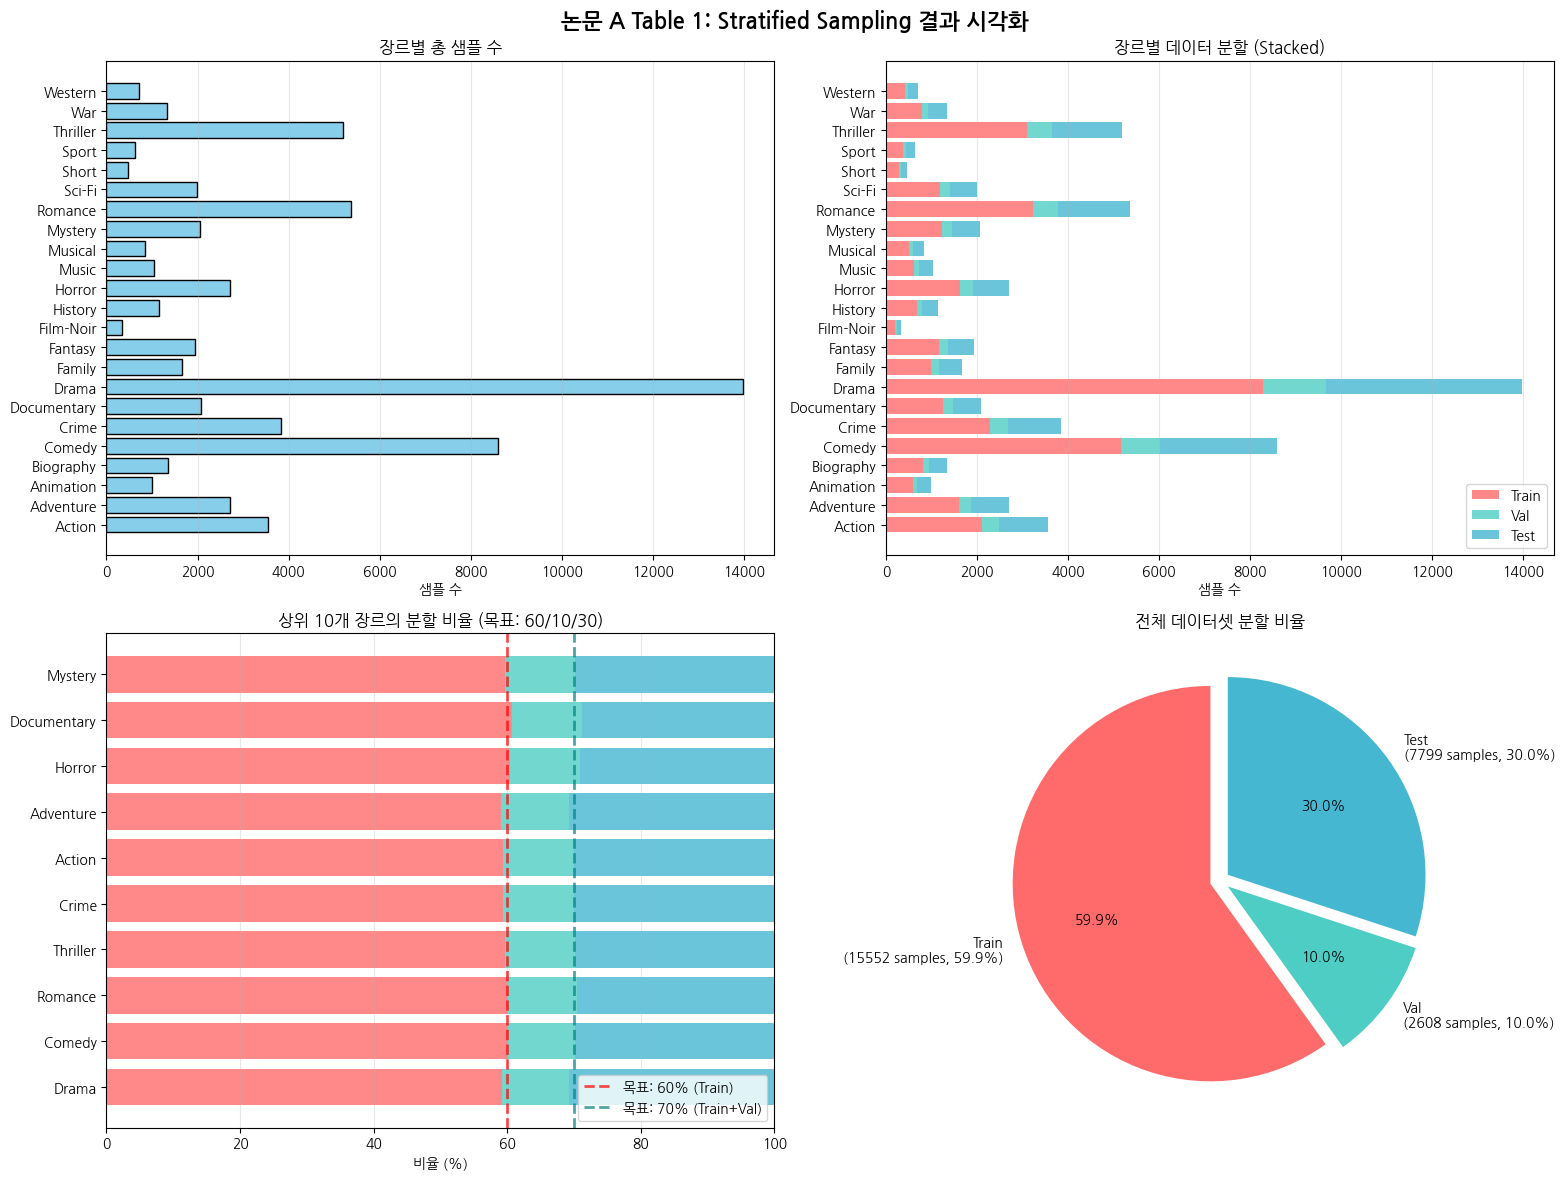

✅ 장르별 분포 시각화 완료


In [5]:
# 장르별 분포 시각화
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. 장르별 총 샘플 수
ax1 = axes[0, 0]
genres_sorted = sorted(all_genres)
total_counts = [train_genre_dist.get(g, 0) + val_genre_dist.get(g, 0) + test_genre_dist.get(g, 0) 
                for g in genres_sorted]
ax1.barh(genres_sorted, total_counts, color='skyblue', edgecolor='black')
ax1.set_xlabel('샘플 수')
ax1.set_title('장르별 총 샘플 수')
ax1.grid(axis='x', alpha=0.3)

# 2. 장르별 Train/Val/Test 분포 (Stacked Bar)
ax2 = axes[0, 1]
train_counts = [train_genre_dist.get(g, 0) for g in genres_sorted]
val_counts = [val_genre_dist.get(g, 0) for g in genres_sorted]
test_counts = [test_genre_dist.get(g, 0) for g in genres_sorted]

x_pos = np.arange(len(genres_sorted))
ax2.barh(x_pos, train_counts, label='Train', color='#FF6B6B', alpha=0.8)
ax2.barh(x_pos, val_counts, left=train_counts, label='Val', color='#4ECDC4', alpha=0.8)
ax2.barh(x_pos, test_counts, left=np.array(train_counts) + np.array(val_counts), 
         label='Test', color='#45B7D1', alpha=0.8)

ax2.set_yticks(x_pos)
ax2.set_yticklabels(genres_sorted)
ax2.set_xlabel('샘플 수')
ax2.set_title('장르별 데이터 분할 (Stacked)')
ax2.legend(loc='lower right')
ax2.grid(axis='x', alpha=0.3)

# 3. 장르별 분할 비율 (목표: 60/10/30)
ax3 = axes[1, 0]
# 상위 10개 장르만 표시 (가독성)
top_10_genres = sorted(all_genres, 
                       key=lambda g: train_genre_dist.get(g, 0) + val_genre_dist.get(g, 0) + test_genre_dist.get(g, 0),
                       reverse=True)[:10]

for i, genre in enumerate(top_10_genres):
    train_count = train_genre_dist.get(genre, 0)
    val_count = val_genre_dist.get(genre, 0)
    test_count = test_genre_dist.get(genre, 0)
    total = train_count + val_count + test_count
    
    if total > 0:
        train_pct = train_count / total * 100
        val_pct = val_count / total * 100
        test_pct = test_count / total * 100
        
        # 비율을 누적 막대로 표시
        ax3.barh(i, train_pct, color='#FF6B6B', alpha=0.8)
        ax3.barh(i, val_pct, left=train_pct, color='#4ECDC4', alpha=0.8)
        ax3.barh(i, test_pct, left=train_pct + val_pct, color='#45B7D1', alpha=0.8)

# 목표 비율 선 추가
ax3.axvline(x=60, color='red', linestyle='--', linewidth=2, alpha=0.7, label='목표: 60% (Train)')
ax3.axvline(x=70, color='teal', linestyle='--', linewidth=2, alpha=0.7, label='목표: 70% (Train+Val)')

ax3.set_yticks(range(len(top_10_genres)))
ax3.set_yticklabels(top_10_genres)
ax3.set_xlabel('비율 (%)')
ax3.set_title('상위 10개 장르의 분할 비율 (목표: 60/10/30)')
ax3.set_xlim(0, 100)
ax3.legend(loc='lower right')
ax3.grid(axis='x', alpha=0.3)

# 4. 데이터셋 크기 비교 (Pie Chart)
ax4 = axes[1, 1]
dataset_sizes = [len(train_ids), len(val_ids), len(test_ids)]
labels = [f'Train\n({len(train_ids)} samples, {len(train_ids)/len(all_movie_ids)*100:.1f}%)',
          f'Val\n({len(val_ids)} samples, {len(val_ids)/len(all_movie_ids)*100:.1f}%)',
          f'Test\n({len(test_ids)} samples, {len(test_ids)/len(all_movie_ids)*100:.1f}%)']
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
explode = (0.05, 0.05, 0.05)

ax4.pie(dataset_sizes, labels=labels, colors=colors, autopct='%1.1f%%', 
        startangle=90, explode=explode, textprops={'fontsize': 10})
ax4.set_title('전체 데이터셋 분할 비율')

plt.suptitle('논문 A Table 1: Stratified Sampling 결과 시각화', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("✅ 장르별 분포 시각화 완료")

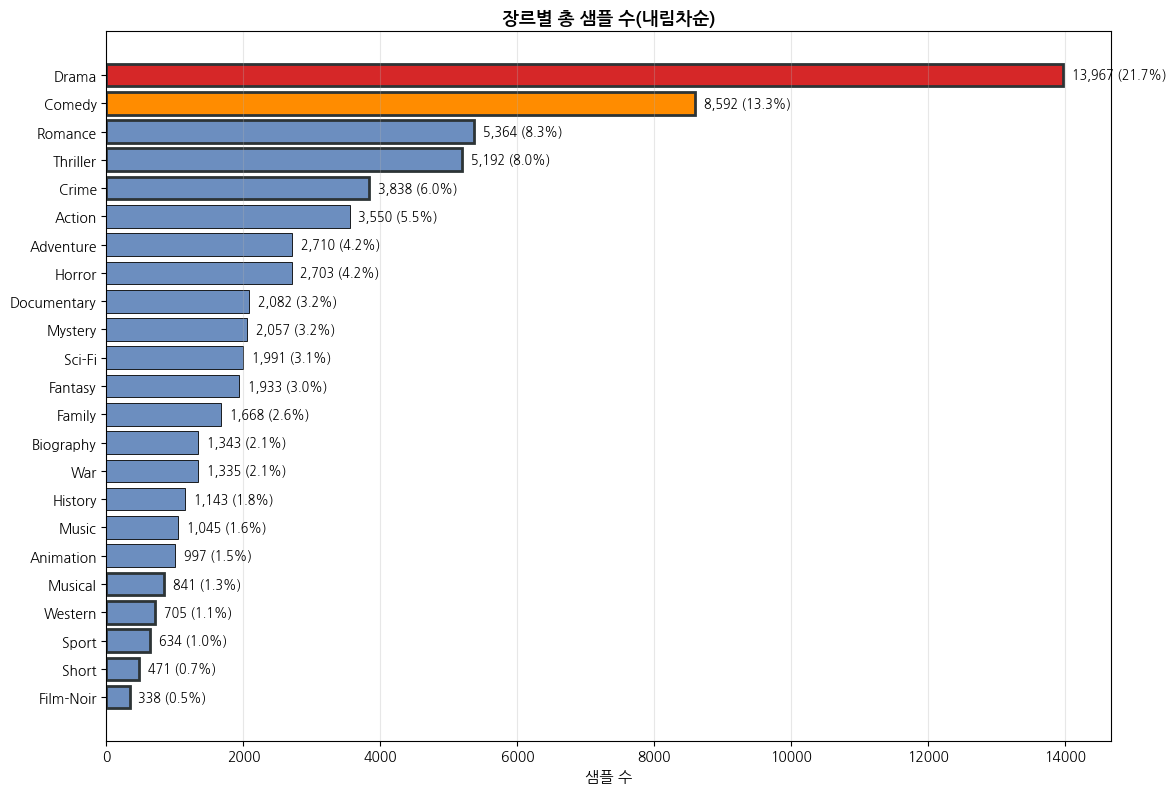

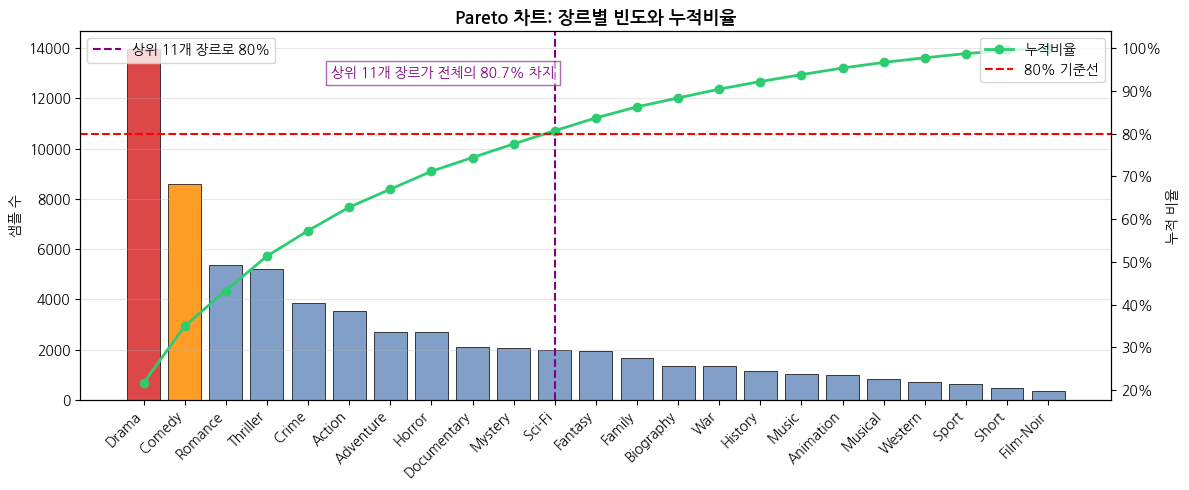

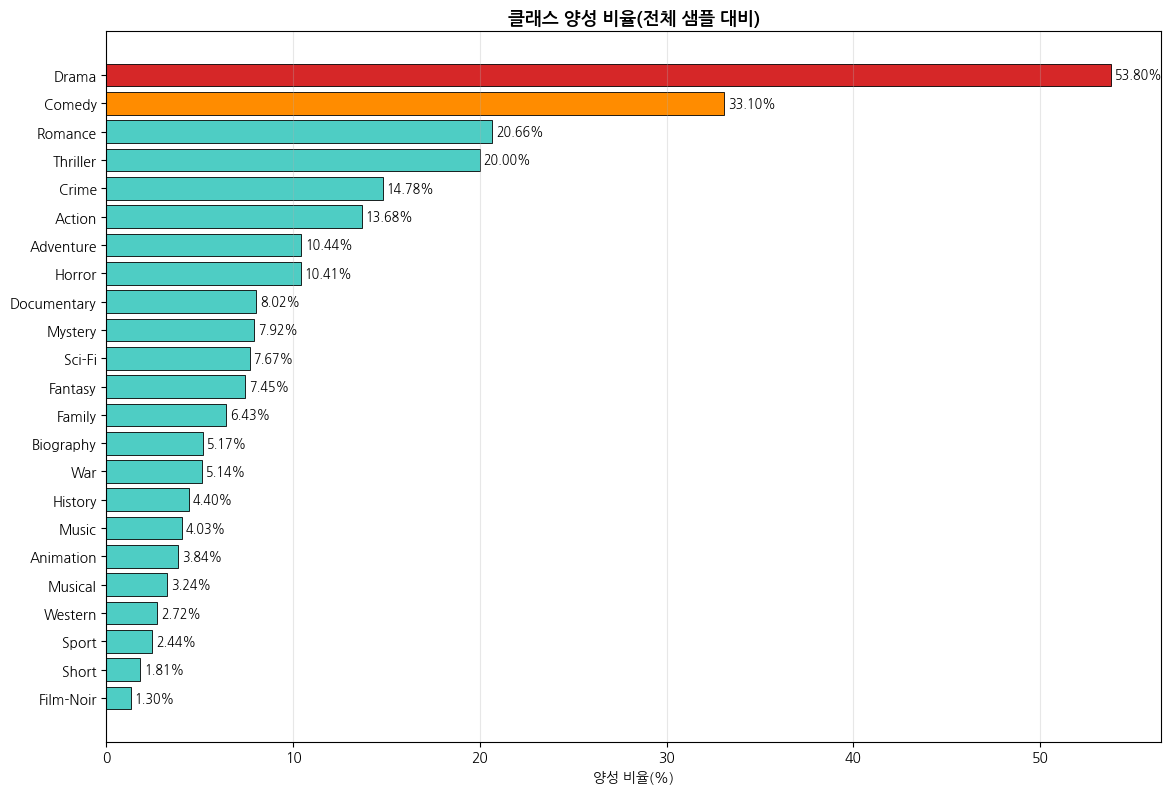


데이터 불균형 요약
- 총 샘플 수 합계(라벨 카운트 합): 64,499
- Pareto: 상위 11개 장르가 전체의 80.69% 차지

[상위 5개 장르]
  Drama            13967건 (21.65%)
  Comedy            8592건 (13.32%)
  Romance           5364건 ( 8.32%)
  Thriller          5192건 ( 8.05%)
  Crime             3838건 ( 5.95%)

[하위 5개 장르]
  Musical            841건 ( 1.30%)
  Western            705건 ( 1.09%)
  Sport              634건 ( 0.98%)
  Short              471건 ( 0.73%)
  Film-Noir          338건 ( 0.52%)

[참고] 강조 장르
  Drama            13967건, 양성비율 53.80%
  Comedy            8592건, 양성비율 33.10%
✅ 장르명 명시 및 불균형(롱테일) 시각화 완료


In [ ]:
# 데이터 불균형(롱테일) 강조 시각화: 장르명을 명확히 표기하고 불균형을 직관적으로 표시
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

# 1) 장르별 총 샘플 수 집계 (Train/Val/Test 합)
total_counts_dict = {
    g: train_genre_dist.get(g, 0) + val_genre_dist.get(g, 0) + test_genre_dist.get(g, 0)
    for g in SELECTED_GENRES
}
genres_sorted_by_count = sorted(total_counts_dict.keys(), key=lambda k: total_counts_dict[k], reverse=True)
counts_sorted = np.array([total_counts_dict[g] for g in genres_sorted_by_count], dtype=np.int64)
total_sum = counts_sorted.sum()

# 2) Pareto(누적비율) 계산
cum_counts = counts_sorted.cumsum()
cum_ratio = cum_counts / total_sum
pareto_threshold = 0.8
k_80 = int(np.argmax(cum_ratio >= pareto_threshold)) + 1  # 상위 k개가 80% 누적에 도달

# 3) 하이라이트(상위/하위 + 특정 장르)
highlight_genres = {'Drama': '#D62728', 'Comedy': '#FF8C00'}
colors = []
for g in genres_sorted_by_count:
    if g in highlight_genres:
        colors.append(highlight_genres[g])
    else:
        colors.append('#6c8ebf')  # 기본색

# 상위 5 / 하위 5 강조 테두리
top5_set = set(genres_sorted_by_count[:5])
bottom5_set = set(genres_sorted_by_count[-5:])

# 4) Figure 1: 장르별 총 샘플 수(내림차순) + 상/하위 강조 + 라벨 주석
fig, ax = plt.subplots(figsize=(12, max(8, len(genres_sorted_by_count)*0.35)))
y_pos = np.arange(len(genres_sorted_by_count))
bars = ax.barh(y_pos, counts_sorted[::-1], color=[colors[::-1][i] for i in range(len(colors))], edgecolor='black', linewidth=0.6)

# ytick 라벨(장르명) 명확히 표시
ax.set_yticks(y_pos)
ax.set_yticklabels(list(reversed(genres_sorted_by_count)), fontsize=10)

# 값 주석
for i, b in enumerate(bars):
    val = int(b.get_width())
    pct = val / total_sum * 100
    ax.text(b.get_width() + max(total_sum*0.002, 1), b.get_y() + b.get_height()/2,
            f'{val:,} ({pct:.1f}%)', va='center', fontsize=9)

# 상위 5, 하위 5에 테두리 강조
for i, g in enumerate(reversed(genres_sorted_by_count)):
    if g in top5_set or g in bottom5_set:
        bars[i].set_linewidth(2.0)
        bars[i].set_edgecolor('#2d3436')

ax.set_title('장르별 총 샘플 수(내림차순)', fontsize=13, fontweight='bold')
ax.set_xlabel('샘플 수', fontsize=11)
ax.grid(axis='x', alpha=0.3)
plt.subplots_adjust(left=0.35)
plt.tight_layout()
plt.show()

# 5) Figure 2: Pareto 차트(막대: 빈도, 선: 누적비율) + 80% 기준선
fig, ax1 = plt.subplots(figsize=(12, 5))
x = np.arange(len(genres_sorted_by_count))
bars = ax1.bar(x, counts_sorted, color=colors, alpha=0.85, edgecolor='black', linewidth=0.6)
ax1.set_ylabel('샘플 수')
ax1.set_xticks(x)
ax1.set_xticklabels(genres_sorted_by_count, rotation=45, ha='right')

ax2 = ax1.twinx()
ax2.plot(x, cum_ratio, color='#2ecc71', marker='o', linewidth=2, label='누적비율')
ax2.yaxis.set_major_formatter(PercentFormatter(1.0))
ax2.set_ylabel('누적 비율')

# 80% 수평선 + 임계 index 수직선
ax2.axhline(y=pareto_threshold, color='red', linestyle='--', linewidth=1.5, label='80% 기준선')
ax1.axvline(x=k_80-1, color='purple', linestyle='--', linewidth=1.5, label=f'상위 {k_80}개 장르로 80%')

# 주석: 상위 k와 대표 장르
ax1.text(k_80-1, max(counts_sorted)*0.95,
         f'상위 {k_80}개 장르가 전체의 {cum_ratio[k_80-1]*100:.1f}% 차지',
         ha='right', va='top', color='purple', fontsize=10, bbox=dict(facecolor='white', alpha=0.6, edgecolor='purple'))

ax1.set_title('Pareto 차트: 장르별 빈도와 누적비율', fontsize=13, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.tight_layout()
plt.show()

# 6) Figure 3: 클래스 양성 비율(전체 Y 기준) - 낮은 비율부터 정렬
num_samples, num_classes = Y.shape
per_class_pos_rate = (Y.sum(axis=0) / num_samples).astype(float)
genre_rates = {g: per_class_pos_rate[SELECTED_GENRES.index(g)] for g in SELECTED_GENRES}
genres_sorted_by_rate = sorted(genre_rates.keys(), key=lambda k: genre_rates[k])  # 오름차순(희소 장르 하이라이트)
rates_sorted = np.array([genre_rates[g] for g in genres_sorted_by_rate])

fig, ax = plt.subplots(figsize=(12, max(8, len(genres_sorted_by_rate)*0.35)))
y_pos = np.arange(len(genres_sorted_by_rate))
bars = ax.barh(y_pos, rates_sorted*100, color=['#4ECDC4' if g not in highlight_genres else highlight_genres[g] for g in genres_sorted_by_rate],
               edgecolor='black', linewidth=0.6)

ax.set_yticks(y_pos)
ax.set_yticklabels(genres_sorted_by_rate, fontsize=10)
ax.set_xlabel('양성 비율(%)')
ax.set_title('클래스 양성 비율(전체 샘플 대비)', fontsize=13, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

# 값 주석
for i, b in enumerate(bars):
    val = b.get_width()
    ax.text(val + 0.2, b.get_y() + b.get_height()/2, f'{val:.2f}%', va='center', fontsize=9)

plt.subplots_adjust(left=0.35)
plt.tight_layout()
plt.show()

# 7) 샘플별 평균 레이블 개수 분석 (멀티레이블 희소성 입증)
labels_per_sample = Y.sum(axis=1)  # 각 샘플별 레이블 개수
label_cardinality = labels_per_sample.mean()  # 평균 레이블 개수
label_density = label_cardinality / num_classes  # 라벨 덴시티

# 전체 1/0 비율
ones = Y.sum()
zeros = Y.size - ones
one_ratio = ones / Y.size
zero_ratio = zeros / Y.size

# '전부 0' 예측 베이스라인 Accuracy (멀티레이블 micro-accuracy)
from sklearn.metrics import accuracy_score
all_zero_pred = np.zeros_like(Y)
baseline_micro_acc = accuracy_score(Y.flatten(), all_zero_pred.flatten())

# Figure 4: 샘플별 레이블 개수 히스토그램
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(labels_per_sample, bins=np.arange(0, labels_per_sample.max()+2)-0.5,
        color='#4ECDC4', edgecolor='black', alpha=0.85)
ax.set_xlabel('샘플당 레이블 개수', fontsize=11)
ax.set_ylabel('샘플 수', fontsize=11)
ax.set_title(f'샘플별 레이블 개수 분포 (평균: {label_cardinality:.2f}개)', fontsize=13, fontweight='bold')
ax.axvline(x=label_cardinality, color='red', linestyle='--', linewidth=2, label=f'평균: {label_cardinality:.2f}')
ax.legend()
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# 8) 콘솔 요약: 상위/하위 5개 장르와 기여도
print("\n" + "="*80)
print("데이터 불균형 및 희소성 분석")
print("="*80)
print(f"- 총 샘플 수: {num_samples:,}")
print(f"- 총 클래스 수: {num_classes}")
print(f"- 총 샘플 수 합계(라벨 카운트 합): {total_sum:,}")
print(f"- Pareto: 상위 {k_80}개 장르가 전체의 {cum_ratio[k_80-1]*100:.2f}% 차지")

print(f"\n[멀티레이블 희소성 지표]")
print(f"- 라벨 카디널리티 (샘플당 평균 레이블 수): {label_cardinality:.3f}")
print(f"- 라벨 덴시티 (카디널리티/클래스 수): {label_density:.4f}")
print(f"- 전체 라벨 중 1(양성) 비율: {one_ratio*100:.2f}%")
print(f"- 전체 라벨 중 0(음성) 비율: {zero_ratio*100:.2f}%")
print(f"- '전부 0' 예측 베이스라인 Micro-Accuracy: {baseline_micro_acc:.4f}")
print(f"  → 이는 Accuracy가 멀티레이블에서 과대평가되는 이유를 보여줍니다.")

print("\n[상위 5개 장르]")
for g in genres_sorted_by_count[:5]:
    print(f"  {g:<15} {total_counts_dict[g]:>6}건 ({total_counts_dict[g]/total_sum*100:5.2f}%)")
print("\n[하위 5개 장르]")
for g in genres_sorted_by_count[-5:]:
    print(f"  {g:<15} {total_counts_dict[g]:>6}건 ({total_counts_dict[g]/total_sum*100:5.2f}%)")
print("\n[참고] 강조 장르")
for g, c in highlight_genres.items():
    if g in total_counts_dict:
        print(f"  {g:<15} {total_counts_dict[g]:>6}건, 양성비율 {genre_rates[g]*100:5.2f}%")
print("✅ 장르명 명시 및 불균형(롱테일) 시각화 완료")

In [10]:
# MM-IMDb 데이터셋 클래스 정의
class MMIMDbDataset(Dataset):
    def __init__(self, movie_ids, dataset_path, genre_to_idx, 
                 img_transform=None, text_tokenizer=None, max_length=512):
        self.movie_ids = movie_ids
        self.dataset_path = dataset_path
        self.genre_to_idx = genre_to_idx
        self.img_transform = img_transform
        self.text_tokenizer = text_tokenizer
        self.max_length = max_length
        self.num_labels = len(genre_to_idx)
        
        # 유효한 ID만 필터링 (이미지와 JSON 파일이 모두 있는 경우)
        self.valid_ids = []
        for movie_id in tqdm(movie_ids, desc="Validating dataset"):
            img_path = os.path.join(dataset_path, f"{movie_id}.jpeg")
            json_path = os.path.join(dataset_path, f"{movie_id}.json")
            
            if os.path.exists(img_path) and os.path.exists(json_path):
                self.valid_ids.append(movie_id)
        
        print(f"Found {len(self.valid_ids)} valid samples out of {len(movie_ids)}")
    
    def __len__(self):
        return len(self.valid_ids)
    
    def __getitem__(self, idx):
        movie_id = self.valid_ids[idx]
        img_path = os.path.join(self.dataset_path, f"{movie_id}.jpeg")
        json_path = os.path.join(self.dataset_path, f"{movie_id}.json")
        
        # 이미지 로드 및 전처리
        try:
            image = Image.open(img_path).convert('RGB')
            if self.img_transform:
                image = self.img_transform(image)
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            # 오류 발생 시 임의의 검은색 이미지 생성
            image = torch.zeros((3, 224, 224))
        
        # JSON 데이터 로드
        with open(json_path, 'r') as f:
            movie_data = json.load(f)
        
        # 텍스트 추출 및 전처리
        plot = " ".join(movie_data.get('plot', [""]))
        
        if self.text_tokenizer:
            text_encoding = self.text_tokenizer(
                plot,
                max_length=self.max_length,
                padding='max_length',
                truncation=True,
                return_tensors='pt'
            )
            
            input_ids = text_encoding['input_ids'].squeeze()
            attention_mask = text_encoding['attention_mask'].squeeze()
            text_inputs = {
                'input_ids': input_ids,
                'attention_mask': attention_mask
            }
        else:
            text_inputs = plot
        
        # 장르 라벨 생성 (원-핫 인코딩)
        genres = movie_data.get('genres', [])
        labels = torch.zeros(self.num_labels)
        for genre in genres:
            if genre in self.genre_to_idx:
                labels[self.genre_to_idx[genre]] = 1.0
        
        return {
            'image': image,
            'text': text_inputs,
            'labels': labels,
            'movie_id': movie_id,
            'plot': plot
        }

In [10]:
# 선택된 23개 장르를 기반으로 genre_to_idx 생성
genre_to_idx = {genre: idx for idx, genre in enumerate(SELECTED_GENRES)}
idx_to_genre = {idx: genre for idx, genre in enumerate(SELECTED_GENRES)}

print(f"✅ 장르 매핑 생성 완료")
print(f"   - 사용할 장르 수: {len(SELECTED_GENRES)}")
print(f"   - 장르 목록: {SELECTED_GENRES}")

✅ 장르 매핑 생성 완료
   - 사용할 장르 수: 23
   - 장르 목록: ['Drama', 'Comedy', 'Romance', 'Thriller', 'Crime', 'Action', 'Adventure', 'Horror', 'Documentary', 'Mystery', 'Sci-Fi', 'Fantasy', 'Family', 'Biography', 'War', 'History', 'Music', 'Animation', 'Musical', 'Western', 'Sport', 'Short', 'Film-Noir']


In [11]:
# 이미지 변환 정의
image_transforms = {
    'train': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# 텍스트 토크나이저 설정
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
roberta_tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# 데이터셋 생성 (BERT 토크나이저 사용)
train_dataset = MMIMDbDataset(
    train_ids, DATASET_PATH, genre_to_idx, 
    img_transform=image_transforms['train'], 
    text_tokenizer=bert_tokenizer
)

val_dataset = MMIMDbDataset(
    val_ids, DATASET_PATH, genre_to_idx, 
    img_transform=image_transforms['val'], 
    text_tokenizer=bert_tokenizer
)

test_dataset = MMIMDbDataset(
    test_ids, DATASET_PATH, genre_to_idx, 
    img_transform=image_transforms['test'], 
    text_tokenizer=bert_tokenizer
)

# 데이터 로더 설정
batch_size = 16

train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True
)

val_loader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True
)

test_loader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True
)

Validating dataset:   0%|          | 0/15552 [00:00<?, ?it/s]

Found 15552 valid samples out of 15552


Validating dataset:   0%|          | 0/2608 [00:00<?, ?it/s]

Found 2608 valid samples out of 2608


Validating dataset:   0%|          | 0/7799 [00:00<?, ?it/s]

Found 7799 valid samples out of 7799


## 3. 모델 아키텍처 구현

### 3.1 특징 추출기 구현

In [12]:
# 이미지 특징 추출기
class ImageFeatureExtractor(nn.Module):
    def __init__(self, feature_extractor='resnet50', pretrained=True, freeze=True):
        super(ImageFeatureExtractor, self).__init__()
        self.feature_extractor = feature_extractor
        
        if feature_extractor == 'resnet50':
            import torchvision.models as tv_models
            self.model = tv_models.resnet50(pretrained=pretrained)
            # 마지막 FC 레이어 제거
            self.model = nn.Sequential(*list(self.model.children())[:-1])
            self.feature_dim = 2048
        elif feature_extractor == 'vit':
            # ViT (Vision Transformer)
            self.model = timm.create_model('vit_base_patch16_224', pretrained=pretrained)
            self.feature_dim = self.model.head.in_features
            # 헤드 제거
            self.model.head = nn.Identity()
            
        # 특징 추출기 레이어 고정 (선택적)
        if freeze:
            for param in self.model.parameters():
                param.requires_grad = False
                
    def forward(self, x):
        features = self.model(x)
        # Reshape: 배치 차원을 유지하면서 flatten
        if self.feature_extractor == 'resnet50':
            features = features.view(features.size(0), -1)
        return features

# 텍스트 특징 추출기
class TextFeatureExtractor(nn.Module):
    def __init__(self, feature_extractor='bert', pretrained=True, freeze=True):
        super(TextFeatureExtractor, self).__init__()
        self.feature_extractor = feature_extractor
        
        if feature_extractor == 'bert':
            self.model = BertModel.from_pretrained('bert-base-uncased')
            self.feature_dim = 768
        elif feature_extractor == 'roberta':
            self.model = RobertaModel.from_pretrained('roberta-base')
            self.feature_dim = 768
            
        # 특징 추출기 레이어 고정 (선택적)
        if freeze:
            for param in self.model.parameters():
                param.requires_grad = False
                
    def forward(self, input_ids, attention_mask):
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
        # [CLS] 토큰 임베딩 사용
        return outputs.last_hidden_state[:, 0, :]

### 3.2 융합 모듈 구현

In [13]:
# 1. Early Fusion (단순 연결)
class EarlyFusionModule(nn.Module):
    def __init__(self, img_feat_dim, text_feat_dim):
        super(EarlyFusionModule, self).__init__()
        self.fusion_dim = img_feat_dim + text_feat_dim
        
    def forward(self, img_features, text_features):
        # 단순히 두 특징 벡터를 연결
        fused_features = torch.cat([img_features, text_features], dim=1)
        return fused_features

# 2. Late Fusion (분류 결과 결합)
class LateFusionModule(nn.Module):
    def __init__(self, img_feat_dim, text_feat_dim, num_classes):
        super(LateFusionModule, self).__init__()
        self.fusion_dim = num_classes
        
        # 이미지 분류기
        self.img_classifier = nn.Sequential(
            nn.Linear(img_feat_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )
        
        # 텍스트 분류기
        self.text_classifier = nn.Sequential(
            nn.Linear(text_feat_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )
        
        # 가중치 학습 파라미터
        self.alpha = nn.Parameter(torch.FloatTensor([0.5]))
        
    def forward(self, img_features, text_features):
        # 각 모달리티별 예측
        img_preds = self.img_classifier(img_features)
        text_preds = self.text_classifier(text_features)
        
        # 가중치 결합
        alpha = torch.sigmoid(self.alpha)
        fused_preds = alpha * img_preds + (1 - alpha) * text_preds
        
        return fused_preds

# 3. Attention Fusion (모달리티 간 어텐션)
class AttentionFusionModule(nn.Module):
    def __init__(self, img_feat_dim, text_feat_dim):
        super(AttentionFusionModule, self).__init__()
        
        # 투영 차원
        self.proj_dim = 512
        
        # 특징 투영 레이어
        self.img_projection = nn.Linear(img_feat_dim, self.proj_dim)
        self.text_projection = nn.Linear(text_feat_dim, self.proj_dim)
        
        # 어텐션 레이어
        self.attention = nn.Sequential(
            nn.Linear(self.proj_dim * 2, 128),
            nn.ReLU(),
            nn.Linear(128, 2),
            nn.Softmax(dim=1)
        )
        
        self.fusion_dim = self.proj_dim
        
    def forward(self, img_features, text_features):
        # 특징 투영
        img_proj = self.img_projection(img_features)
        text_proj = self.text_projection(text_features)
        
        # 연결하여 어텐션 가중치 계산
        combined = torch.cat([img_proj, text_proj], dim=1)
        attention_weights = self.attention(combined)
        
        # 가중치 적용 및 결합
        fused_features = attention_weights[:, 0].unsqueeze(1) * img_proj + \
                          attention_weights[:, 1].unsqueeze(1) * text_proj
        
        return fused_features

# 4. Cross-Attention Fusion (교차 어텐션)
class CrossAttentionFusionModule(nn.Module):
    def __init__(self, img_feat_dim, text_feat_dim):
        super(CrossAttentionFusionModule, self).__init__()
        
        # 투영 차원
        self.proj_dim = 512
        
        # 특징 투영 레이어
        self.img_projection = nn.Linear(img_feat_dim, self.proj_dim)
        self.text_projection = nn.Linear(text_feat_dim, self.proj_dim)
        
        # Cross-Attention 레이어
        self.q_img = nn.Linear(self.proj_dim, self.proj_dim)
        self.k_text = nn.Linear(self.proj_dim, self.proj_dim)
        self.v_text = nn.Linear(self.proj_dim, self.proj_dim)
        
        self.q_text = nn.Linear(self.proj_dim, self.proj_dim)
        self.k_img = nn.Linear(self.proj_dim, self.proj_dim)
        self.v_img = nn.Linear(self.proj_dim, self.proj_dim)
        
        self.norm1 = nn.LayerNorm(self.proj_dim)
        self.norm2 = nn.LayerNorm(self.proj_dim)
        
        self.fusion_dim = self.proj_dim * 2
        
    def forward(self, img_features, text_features):
        # 특징 투영
        img_proj = self.img_projection(img_features)
        text_proj = self.text_projection(text_features)
        
        # 이미지 -> 텍스트 Cross-Attention
        q_img = self.q_img(img_proj)
        k_text = self.k_text(text_proj)
        v_text = self.v_text(text_proj)
        
        # 스케일링된 내적 어텐션
        attn_scores = torch.matmul(q_img, k_text.transpose(-2, -1)) / (self.proj_dim ** 0.5)
        attn_weights = F.softmax(attn_scores, dim=-1)
        attended_text = torch.matmul(attn_weights, v_text)
        img_attended = self.norm1(img_proj + attended_text)
        
        # 텍스트 -> 이미지 Cross-Attention
        q_text = self.q_text(text_proj)
        k_img = self.k_img(img_proj)
        v_img = self.v_img(img_proj)
        
        attn_scores = torch.matmul(q_text, k_img.transpose(-2, -1)) / (self.proj_dim ** 0.5)
        attn_weights = F.softmax(attn_scores, dim=-1)
        attended_img = torch.matmul(attn_weights, v_img)
        text_attended = self.norm2(text_proj + attended_img)
        
        # 최종 결합
        fused_features = torch.cat([img_attended, text_attended], dim=1)
        
        return fused_features

# 5. GMU (Gated Multimodal Unit) - 논문 A의 제안 모델
class GatedBimodalUnit(nn.Module):
    """
    Gated Bimodal Unit (GMU)
    논문: Gated Multimodal Units for Information Fusion (ICLR 2018 Workshop)
    
    두 모달리티를 gate 메커니즘으로 융합
    z = σ(W * [h_v; h_t])
    output = z ⊙ h_v + (1-z) ⊙ h_t
    """
    def __init__(self, dim):
        super(GatedBimodalUnit, self).__init__()
        self.dim = dim
        
        # Gate 가중치: [h_v; h_t] -> z
        self.gate = nn.Sequential(
            nn.Linear(dim * 2, dim),
            nn.Sigmoid()
        )
        
        # Activation for hidden representations
        self.activation = nn.Tanh()
        
    def forward(self, h_visual, h_textual):
        """
        Args:
            h_visual: 이미지 hidden representation [batch, dim]
            h_textual: 텍스트 hidden representation [batch, dim]
        Returns:
            fused: gated fusion output [batch, dim]
            z: gate values [batch, dim] (분석용)
        """
        # 두 hidden representation을 결합
        h_concat = torch.cat([h_visual, h_textual], dim=1)
        
        # Activation 적용
        h = self.activation(h_concat)
        h_v = h[:, :self.dim]
        h_t = h[:, self.dim:]
        
        # Gate 계산
        z = self.gate(h_concat)
        
        # Gated fusion: z * h_v + (1-z) * h_t
        fused = z * h_v + (1 - z) * h_t
        
        return fused, z

class GMUFusionModule(nn.Module):
    """
    GMU (Gated Multimodal Unit) Fusion Module
    논문 A의 제안 방법
    """
    def __init__(self, img_feat_dim, text_feat_dim, hidden_dim=512):
        super(GMUFusionModule, self).__init__()
        
        self.hidden_dim = hidden_dim
        
        # 각 모달리티를 hidden dimension으로 투영
        self.visual_projection = nn.Sequential(
            nn.BatchNorm1d(img_feat_dim),
            nn.Linear(img_feat_dim, hidden_dim, bias=False)
        )
        
        self.textual_projection = nn.Sequential(
            nn.BatchNorm1d(text_feat_dim),
            nn.Linear(text_feat_dim, hidden_dim, bias=False)
        )
        
        # Gated Bimodal Unit
        self.gbu = GatedBimodalUnit(hidden_dim)
        
        self.fusion_dim = hidden_dim
        
    def forward(self, img_features, text_features):
        # 각 모달리티를 hidden space로 투영
        h_visual = self.visual_projection(img_features)
        h_textual = self.textual_projection(text_features)
        
        # GMU로 융합
        fused_features, gate_values = self.gbu(h_visual, h_textual)
        
        return fused_features

### 3.3 최종 멀티모달 모델 구현

In [14]:
# 멀티모달 융합 모델
class MultimodalModel(nn.Module):
    def __init__(self, num_classes, img_extractor='resnet50', text_extractor='bert', 
                 fusion_method='early', freeze_extractors=True):
        super(MultimodalModel, self).__init__()
        
        # 이미지 특징 추출기 초기화
        self.img_extractor = ImageFeatureExtractor(img_extractor, pretrained=True, freeze=freeze_extractors)
        
        # 텍스트 특징 추출기 초기화
        self.text_extractor = TextFeatureExtractor(text_extractor, pretrained=True, freeze=freeze_extractors)
        
        # 융합 방식 설정
        self.fusion_method = fusion_method
        
        # 적절한 융합 모듈 선택
        if fusion_method == 'early':
            self.fusion_module = EarlyFusionModule(
                self.img_extractor.feature_dim, self.text_extractor.feature_dim
            )
            fusion_dim = self.img_extractor.feature_dim + self.text_extractor.feature_dim
            
        elif fusion_method == 'late':
            self.fusion_module = LateFusionModule(
                self.img_extractor.feature_dim, self.text_extractor.feature_dim, num_classes
            )
            # Late Fusion은 직접 출력값 생성
            fusion_dim = num_classes
            
        elif fusion_method == 'attention':
            self.fusion_module = AttentionFusionModule(
                self.img_extractor.feature_dim, self.text_extractor.feature_dim
            )
            fusion_dim = self.fusion_module.fusion_dim
            
        elif fusion_method == 'cross-attention':
            self.fusion_module = CrossAttentionFusionModule(
                self.img_extractor.feature_dim, self.text_extractor.feature_dim
            )
            fusion_dim = self.fusion_module.fusion_dim
            
        elif fusion_method == 'gmu':
            self.fusion_module = GMUFusionModule(
                self.img_extractor.feature_dim, self.text_extractor.feature_dim
            )
            fusion_dim = self.fusion_module.fusion_dim
            
        else:
            raise ValueError(f"Unknown fusion method: {fusion_method}")
        
        # 분류기 (Late Fusion은 필요 없음)
        if fusion_method != 'late':
            self.classifier = nn.Sequential(
                nn.Linear(fusion_dim, 512),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(512, 256),
                nn.ReLU(),
                nn.Dropout(0.2),
                nn.Linear(256, num_classes)
            )
            
    def forward(self, image, text_inputs):
        # 이미지 특징 추출
        img_features = self.img_extractor(image)
        
        # 텍스트 특징 추출
        text_features = self.text_extractor(
            input_ids=text_inputs['input_ids'], 
            attention_mask=text_inputs['attention_mask']
        )
        
        # 특징 융합
        if self.fusion_method == 'late':
            # Late Fusion은 직접 예측값 반환
            logits = self.fusion_module(img_features, text_features)
        else:
            # 다른 융합 방법들은 융합된 특징 반환
            fused_features = self.fusion_module(img_features, text_features)
            logits = self.classifier(fused_features)
            
        return logits

# 단일 모달 모델 (이미지만 또는 텍스트만)
class SingleModalModel(nn.Module):
    def __init__(self, num_classes, modality='image', extractor='resnet50', freeze_extractor=True):
        super(SingleModalModel, self).__init__()
        
        self.modality = modality
        
        if modality == 'image':
            self.feature_extractor = ImageFeatureExtractor(extractor, pretrained=True, freeze=freeze_extractor)
        elif modality == 'text':
            self.feature_extractor = TextFeatureExtractor(extractor, pretrained=True, freeze=freeze_extractor)
        else:
            raise ValueError(f"Unknown modality: {modality}")
        
        # 분류기
        self.classifier = nn.Sequential(
            nn.Linear(self.feature_extractor.feature_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, num_classes)
        )
        
    def forward(self, inputs):
        if self.modality == 'image':
            features = self.feature_extractor(inputs)
        else:  # text
            features = self.feature_extractor(
                input_ids=inputs['input_ids'], 
                attention_mask=inputs['attention_mask']
            )
            
        logits = self.classifier(features)
        return logits

## 4. 모델 학습 및 평가 함수

In [21]:
# 모델 학습 함수
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler=None, 
                num_epochs=10, device=device, early_stop_patience=5):
    
    # 학습 기록을 위한 딕셔너리 (F1 지표 확장)
    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': [],
        'train_f1_macro': [], 'val_f1_macro': [],
        'train_f1_micro': [], 'val_f1_micro': [],
        'train_f1_weighted': [], 'val_f1_weighted': [],
        'train_f1_samples': [], 'val_f1_samples': []
    }
    
    # 조기 종료를 위한 변수
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_weights = None
    
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        
        # 훈련 모드
        model.train()
        train_loss = 0.0
        train_preds = []
        train_targets = []
        
        # 훈련 데이터 처리
        for batch in tqdm(train_loader, desc="Training"):
            # 데이터 준비
            images = batch['image'].to(device)
            
            if isinstance(model, MultimodalModel):
                text_inputs = {
                    'input_ids': batch['text']['input_ids'].to(device),
                    'attention_mask': batch['text']['attention_mask'].to(device)
                }
                targets = batch['labels'].to(device)
                
                # 순전파
                outputs = model(images, text_inputs)
                
            elif isinstance(model, SingleModalModel):
                if model.modality == 'image':
                    inputs = images
                else:  # text
                    inputs = {
                        'input_ids': batch['text']['input_ids'].to(device),
                        'attention_mask': batch['text']['attention_mask'].to(device)
                    }
                targets = batch['labels'].to(device)
                
                # 순전파
                outputs = model(inputs)
            
            # 손실 계산
            loss = criterion(outputs, targets)
            
            # 역전파 및 최적화
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # 통계 업데이트
            train_loss += loss.item() * images.size(0)
            train_preds.append(torch.sigmoid(outputs).cpu().detach().numpy())
            train_targets.append(targets.cpu().numpy())
        
        # 에폭 평균 손실
        train_loss = train_loss / len(train_loader.dataset)
        
        # 예측 및 타겟 배열 결합
        train_preds = np.vstack(train_preds)
        train_targets = np.vstack(train_targets)
        
        # 임계값 적용하여 이진 분류 결과 얻기
        train_preds_binary = (train_preds > 0.5).astype(float)
        
        # 성능 지표 계산 (멀티레이블 지표 확장)
        train_acc = accuracy_score(train_targets.flatten(), train_preds_binary.flatten())
        train_f1_macro = f1_score(train_targets, train_preds_binary, average='macro', zero_division=0)
        train_f1_micro = f1_score(train_targets, train_preds_binary, average='micro', zero_division=0)
        train_f1_weighted = f1_score(train_targets, train_preds_binary, average='weighted', zero_division=0)
        train_f1_samples = f1_score(train_targets, train_preds_binary, average='samples', zero_division=0)
        
        # 검증 모드
        model.eval()
        val_loss = 0.0
        val_preds = []
        val_targets = []
        
        with torch.no_grad():
            for batch in tqdm(val_loader, desc="Validation"):
                # 데이터 준비
                images = batch['image'].to(device)
                
                if isinstance(model, MultimodalModel):
                    text_inputs = {
                        'input_ids': batch['text']['input_ids'].to(device),
                        'attention_mask': batch['text']['attention_mask'].to(device)
                    }
                    targets = batch['labels'].to(device)
                    
                    # 순전파
                    outputs = model(images, text_inputs)
                    
                elif isinstance(model, SingleModalModel):
                    if model.modality == 'image':
                        inputs = images
                    else:  # text
                        inputs = {
                            'input_ids': batch['text']['input_ids'].to(device),
                            'attention_mask': batch['text']['attention_mask'].to(device)
                        }
                    targets = batch['labels'].to(device)
                    
                    # 순전파
                    outputs = model(inputs)
                
                # 손실 계산
                loss = criterion(outputs, targets)
                
                # 통계 업데이트
                val_loss += loss.item() * images.size(0)
                val_preds.append(torch.sigmoid(outputs).cpu().numpy())
                val_targets.append(targets.cpu().numpy())
        
        # 에폭 평균 손실
        val_loss = val_loss / len(val_loader.dataset)
        
        # 예측 및 타겟 배열 결합
        val_preds = np.vstack(val_preds)
        val_targets = np.vstack(val_targets)
        
        # 임계값 적용하여 이진 분류 결과 얻기
        val_preds_binary = (val_preds > 0.5).astype(float)
        
        # 성능 지표 계산 (멀티레이블 지표 확장)
        val_acc = accuracy_score(val_targets.flatten(), val_preds_binary.flatten())
        val_f1_macro = f1_score(val_targets, val_preds_binary, average='macro', zero_division=0)
        val_f1_micro = f1_score(val_targets, val_preds_binary, average='micro', zero_division=0)
        val_f1_weighted = f1_score(val_targets, val_preds_binary, average='weighted', zero_division=0)
        val_f1_samples = f1_score(val_targets, val_preds_binary, average='samples', zero_division=0)
        
        # 학습률 스케줄러 업데이트 (있는 경우)
        if scheduler:
            scheduler.step(val_loss)
        
        # 기록 저장
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['train_f1_macro'].append(train_f1_macro)
        history['val_f1_macro'].append(val_f1_macro)
        history['train_f1_micro'].append(train_f1_micro)
        history['val_f1_micro'].append(val_f1_micro)
        history['train_f1_weighted'].append(train_f1_weighted)
        history['val_f1_weighted'].append(val_f1_weighted)
        history['train_f1_samples'].append(train_f1_samples)
        history['val_f1_samples'].append(val_f1_samples)
        
        # 에폭 결과 출력
        print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
        print(f"Train Acc (micro): {train_acc:.4f}, Val Acc (micro): {val_acc:.4f}")
        print(f"Train F1 - Macro: {train_f1_macro:.4f}, Micro: {train_f1_micro:.4f}, Weighted: {train_f1_weighted:.4f}, Samples: {train_f1_samples:.4f}")
        print(f"Val F1 - Macro: {val_f1_macro:.4f}, Micro: {val_f1_micro:.4f}, Weighted: {val_f1_weighted:.4f}, Samples: {val_f1_samples:.4f}")
        print("-" * 50)
        
        # 최고 성능 모델 저장
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_weights = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
            
        # 조기 종료
        if patience_counter >= early_stop_patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    
    # 최고 성능 모델로 복원
    if best_model_weights:
        model.load_state_dict(best_model_weights)
        
    return model, history

# 모델 평가 함수 (논문 A의 지표 및 멀티레이블 전용 지표 추가)
def evaluate_model(model, test_loader, criterion, device=device):
    """
    모델 평가 함수 (논문 A의 Table 2와 동일한 F-score 지표 포함)
    - F-score: weighted, samples, micro, macro
    - 멀티레이블 전용 지표: subset_accuracy, hamming_accuracy, jaccard_samples
    """
    # 평가 모드
    model.eval()
    test_loss = 0.0
    all_preds = []
    all_targets = []
    all_probs = []
    
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Testing"):
            # 데이터 준비
            images = batch['image'].to(device)
            
            if isinstance(model, MultimodalModel):
                text_inputs = {
                    'input_ids': batch['text']['input_ids'].to(device),
                    'attention_mask': batch['text']['attention_mask'].to(device)
                }
                targets = batch['labels'].to(device)
                
                # 순전파
                outputs = model(images, text_inputs)
                
            elif isinstance(model, SingleModalModel):
                if model.modality == 'image':
                    inputs = images
                else:  # text
                    inputs = {
                        'input_ids': batch['text']['input_ids'].to(device),
                        'attention_mask': batch['text']['attention_mask'].to(device)
                    }
                targets = batch['labels'].to(device)
                
                # 순전파
                outputs = model(inputs)
            
            # 손실 계산
            loss = criterion(outputs, targets)
            
            # 통계 업데이트
            test_loss += loss.item() * images.size(0)
            
            # 예측값 저장
            probabilities = torch.sigmoid(outputs).cpu().numpy()
            all_probs.append(probabilities)
            all_preds.append((probabilities > 0.5).astype(float))
            all_targets.append(targets.cpu().numpy())
    
    # 평균 손실
    test_loss = test_loss / len(test_loader.dataset)
    
    # 예측 및 타겟 배열 결합
    all_probs = np.vstack(all_probs)
    all_preds = np.vstack(all_preds)
    all_targets = np.vstack(all_targets)
    
    # 멀티레이블 전용 지표 추가
    from sklearn.metrics import hamming_loss, jaccard_score
    
    accuracy_micro = accuracy_score(all_targets.flatten(), all_preds.flatten())  # TN 포함(높아지기 쉬움)
    subset_accuracy = accuracy_score(all_targets, all_preds)                     # Exact match
    hamming_accuracy = 1.0 - hamming_loss(all_targets, all_preds)               # 라벨 단위 평균 정확도
    jaccard_samples = jaccard_score(all_targets, all_preds, average='samples', zero_division=0)
    
    # 평가 지표 계산
    metrics = {
        'loss': test_loss,
        
        # Accuracy 지표들 (명확히 표기)
        'accuracy_micro': accuracy_micro,       # 기존 accuracy와 동일 의미 (TN 포함)
        'subset_accuracy': subset_accuracy,     # 모든 라벨이 정확히 일치
        'hamming_accuracy': hamming_accuracy,   # 라벨별 평균 정확도
        'jaccard_samples': jaccard_samples,     # 샘플별 Jaccard 유사도
        
        # Precision
        'precision_macro': precision_score(all_targets, all_preds, average='macro', zero_division=0),
        'precision_micro': precision_score(all_targets, all_preds, average='micro', zero_division=0),
        'precision_weighted': precision_score(all_targets, all_preds, average='weighted', zero_division=0),
        
        # Recall
        'recall_macro': recall_score(all_targets, all_preds, average='macro', zero_division=0),
        'recall_micro': recall_score(all_targets, all_preds, average='micro', zero_division=0),
        'recall_weighted': recall_score(all_targets, all_preds, average='weighted', zero_division=0),
        
        # F1-score (논문 A의 주요 지표)
        'f1_macro': f1_score(all_targets, all_preds, average='macro', zero_division=0),
        'f1_micro': f1_score(all_targets, all_preds, average='micro', zero_division=0),
        'f1_weighted': f1_score(all_targets, all_preds, average='weighted', zero_division=0),
        'f1_samples': f1_score(all_targets, all_preds, average='samples', zero_division=0),
    }
    
    # ROC-AUC 계산 (클래스별로 유효한 것만)
    try:
        # 각 클래스별로 ROC-AUC 계산 가능한지 확인
        valid_class_aucs = []
        for class_idx in range(all_targets.shape[1]):
            class_targets = all_targets[:, class_idx]
            class_probs = all_probs[:, class_idx]
            
            # 클래스에 positive와 negative 샘플이 모두 있는지 확인
            unique_targets = np.unique(class_targets)
            if len(unique_targets) >= 2:  # 0과 1이 모두 있어야 함
                try:
                    auc = roc_auc_score(class_targets, class_probs)
                    valid_class_aucs.append(auc)
                except:
                    continue
        
        if valid_class_aucs:
            # 유효한 클래스들의 평균으로 계산
            roc_auc_macro = np.mean(valid_class_aucs)
            metrics['roc_auc'] = roc_auc_macro
            
            # Micro-average도 시도
            try:
                roc_auc_micro = roc_auc_score(all_targets.ravel(), all_probs.ravel())
                metrics['roc_auc_micro'] = roc_auc_micro
            except:
                metrics['roc_auc_micro'] = roc_auc_macro
        else:
            metrics['roc_auc'] = float('nan')
            metrics['roc_auc_micro'] = float('nan')
            
    except Exception as e:
        print(f"ROC-AUC 계산 중 오류: {e}")
        metrics['roc_auc'] = float('nan')
        metrics['roc_auc_micro'] = float('nan')
        
    # mAP(Average Precision) 계산
    try:
        # 각 클래스별로 mAP 계산 가능한지 확인
        valid_class_aps = []
        for class_idx in range(all_targets.shape[1]):
            class_targets = all_targets[:, class_idx]
            class_probs = all_probs[:, class_idx]
            
            unique_targets = np.unique(class_targets)
            if len(unique_targets) >= 2:
                try:
                    ap = average_precision_score(class_targets, class_probs)
                    valid_class_aps.append(ap)
                except:
                    continue
        
        if valid_class_aps:
            mAP_macro = np.mean(valid_class_aps)
            metrics['mAP'] = mAP_macro
            
            # Micro-average도 시도
            try:
                mAP_micro = average_precision_score(all_targets.ravel(), all_probs.ravel())
                metrics['mAP_micro'] = mAP_micro
            except:
                metrics['mAP_micro'] = mAP_macro
        else:
            metrics['mAP'] = float('nan')
            metrics['mAP_micro'] = float('nan')
            
    except Exception as e:
        print(f"mAP 계산 중 오류: {e}")
        metrics['mAP'] = float('nan')
        metrics['mAP_micro'] = float('nan')
    
    # 장르별 성능 지표 계산 (per_genre_metrics)
    per_genre_metrics = {}
    for genre_idx, genre_name in enumerate(SELECTED_GENRES):
        genre_targets = all_targets[:, genre_idx]
        genre_preds = all_preds[:, genre_idx]
        genre_probs = all_probs[:, genre_idx]
        
        # 해당 장르의 샘플이 있는지 확인
        if len(np.unique(genre_targets)) > 1:
            per_genre_metrics[genre_name] = {
                'accuracy': accuracy_score(genre_targets, genre_preds),
                'precision': precision_score(genre_targets, genre_preds, zero_division=0),
                'recall': recall_score(genre_targets, genre_preds, zero_division=0),
                'f1': f1_score(genre_targets, genre_preds, zero_division=0),
                'support': int(np.sum(genre_targets))
            }
            
            # ROC-AUC 계산 시도
            try:
                per_genre_metrics[genre_name]['roc_auc'] = roc_auc_score(genre_targets, genre_probs)
            except:
                per_genre_metrics[genre_name]['roc_auc'] = float('nan')
    
    metrics['per_genre_metrics'] = per_genre_metrics
        
    return metrics, all_preds, all_probs, all_targets

In [16]:
# 시각화 함수 정의
def plot_training_history(history, title='모델 학습 결과'):
    """학습 과정에서의 손실 및 성능 지표 시각화"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    # 손실 곡선
    axes[0, 0].plot(history['train_loss'], label='Train Loss')
    axes[0, 0].plot(history['val_loss'], label='Validation Loss')
    axes[0, 0].set_title('손실 추이')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True)
    
    # 정확도 곡선 (Micro)
    axes[0, 1].plot(history['train_acc'], label='Train Accuracy (Micro)')
    axes[0, 1].plot(history['val_acc'], label='Validation Accuracy (Micro)')
    axes[0, 1].set_title('정확도 추이 (Micro - TN 포함)')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].legend()
    axes[0, 1].grid(True)
    
    # F1 Macro 곡선
    axes[0, 2].plot(history['train_f1_macro'], label='Train F1 Macro')
    axes[0, 2].plot(history['val_f1_macro'], label='Validation F1 Macro')
    axes[0, 2].set_title('F1 Macro 점수 추이')
    axes[0, 2].set_xlabel('Epoch')
    axes[0, 2].set_ylabel('F1 Score (Macro)')
    axes[0, 2].legend()
    axes[0, 2].grid(True)
    
    # F1 Micro 곡선
    axes[1, 0].plot(history['train_f1_micro'], label='Train F1 Micro')
    axes[1, 0].plot(history['val_f1_micro'], label='Validation F1 Micro')
    axes[1, 0].set_title('F1 Micro 점수 추이')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('F1 Score (Micro)')
    axes[1, 0].legend()
    axes[1, 0].grid(True)
    
    # F1 Weighted 곡선
    axes[1, 1].plot(history['train_f1_weighted'], label='Train F1 Weighted')
    axes[1, 1].plot(history['val_f1_weighted'], label='Validation F1 Weighted')
    axes[1, 1].set_title('F1 Weighted 점수 추이')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('F1 Score (Weighted)')
    axes[1, 1].legend()
    axes[1, 1].grid(True)
    
    # F1 Samples 곡선
    axes[1, 2].plot(history['train_f1_samples'], label='Train F1 Samples')
    axes[1, 2].plot(history['val_f1_samples'], label='Validation F1 Samples')
    axes[1, 2].set_title('F1 Samples 점수 추이')
    axes[1, 2].set_xlabel('Epoch')
    axes[1, 2].set_ylabel('F1 Score (Samples)')
    axes[1, 2].legend()
    axes[1, 2].grid(True)
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()
    
def plot_confusion_matrix(y_true, y_pred, classes, title='Confusion Matrix'):
    """다중 레이블 분류를 위한 혼동 행렬 시각화"""
    # 평균 혼동 행렬 계산
    mcm = multilabel_confusion_matrix(y_true, y_pred)
    
    fig, axes = plt.subplots(4, 6, figsize=(20, 15))
    axes = axes.flatten()
    
    for i, (ax, cm, label) in enumerate(zip(axes, mcm, classes)):
        if i < len(classes):
            # 클래스별 혼동 행렬 시각화
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
            ax.set_title(f'Class: {label}')
            ax.set_xlabel('Predicted')
            ax.set_ylabel('True')
            ax.set_xticks([0.5, 1.5])
            ax.set_xticklabels(['Negative', 'Positive'])
            ax.set_yticks([0.5, 1.5])
            ax.set_yticklabels(['Negative', 'Positive'])
    
    # 남은 축 숨기기
    for i in range(len(classes), len(axes)):
        axes[i].axis('off')
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

def plot_metrics_comparison(model_results, metric_keys=None):
    """여러 모델의 성능 지표 비교"""
    if metric_keys is None:
        # 논문 A와 동일한 주요 지표
        metric_keys = ['f1_macro', 'f1_micro', 'f1_weighted', 'f1_samples', 
                      'accuracy_micro', 'subset_accuracy']
    
    models = list(model_results.keys())
    metrics_data = {key: [] for key in metric_keys}
    
    for model_name in models:
        test_metrics = model_results[model_name]['test_metrics']
        for key in metric_keys:
            value = test_metrics.get(key, 0)
            metrics_data[key].append(value if not np.isnan(value) else 0)
    
    # 막대 그래프 생성
    x = np.arange(len(models))
    width = 0.12
    
    fig, ax = plt.subplots(figsize=(16, 8))
    
    for i, key in enumerate(metric_keys):
        offset = width * (i - len(metric_keys)/2)
        ax.bar(x + offset, metrics_data[key], width, label=key)
    
    ax.set_xlabel('Models')
    ax.set_ylabel('Score')
    ax.set_title('모델별 성능 지표 비교 (논문 A 지표 포함)')
    ax.set_xticks(x)
    ax.set_xticklabels(models, rotation=45, ha='right')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

In [17]:
def print_per_genre_metrics(per_genre_metrics, title="장르별 성능 지표 (논문 A Table 3 형식)"):
    """
    장르별 성능 지표를 표 형식으로 출력 (논문 A의 Table 3과 유사)
    """
    print(f"\n{'='*80}")
    print(f"{title:^80}")
    print(f"{'='*80}")
    print(f"{'Genre':<20} {'Accuracy':>10} {'Precision':>10} {'Recall':>10} {'F1-Score':>10} {'Support':>10}")
    print(f"{'-'*80}")
    
    # 장르명으로 정렬
    sorted_genres = sorted(per_genre_metrics.items())
    
    for genre, metrics in sorted_genres:
        print(f"{genre:<20} {metrics['accuracy']:>10.4f} {metrics['precision']:>10.4f} "
              f"{metrics['recall']:>10.4f} {metrics['f1']:>10.4f} {metrics['support']:>10}")
    
    print(f"{'='*80}\n")
    
    # 평균 지표 계산 및 출력
    avg_accuracy = np.mean([m['accuracy'] for m in per_genre_metrics.values()])
    avg_precision = np.mean([m['precision'] for m in per_genre_metrics.values()])
    avg_recall = np.mean([m['recall'] for m in per_genre_metrics.values()])
    avg_f1 = np.mean([m['f1'] for m in per_genre_metrics.values()])
    total_support = sum([m['support'] for m in per_genre_metrics.values()])
    
    print(f"{'MACRO AVERAGE':<20} {avg_accuracy:>10.4f} {avg_precision:>10.4f} "
          f"{avg_recall:>10.4f} {avg_f1:>10.4f} {total_support:>10}")
    print(f"{'='*80}\n")

def print_fscore_comparison(metrics, title="F-Score 비교 (논문 A Table 2 형식)"):
    """
    F-score의 다양한 averaging 방법 비교 출력
    """
    print(f"\n{'='*60}")
    print(f"{title:^60}")
    print(f"{'='*60}")
    print(f"{'Metric':<30} {'Score':>20}")
    print(f"{'-'*60}")
    
    print(f"{'F1-Score (Macro)':<30} {metrics.get('f1_macro', 0):>20.4f}")
    print(f"{'F1-Score (Micro)':<30} {metrics.get('f1_micro', 0):>20.4f}")
    print(f"{'F1-Score (Weighted)':<30} {metrics.get('f1_weighted', 0):>20.4f}")
    print(f"{'F1-Score (Samples)':<30} {metrics.get('f1_samples', 0):>20.4f}")
    
    print(f"{'='*60}\n")

print("장르별 성능 지표 출력 함수가 추가되었습니다.")

장르별 성능 지표 출력 함수가 추가되었습니다.


In [18]:
def evaluate_model(model, test_loader, criterion, device=device):
    """
    모델 평가 함수 (논문 A의 Table 2와 동일한 F-score 지표 포함)
    - F-score: weighted, samples, micro, macro
    """
    model.eval()
    test_loss = 0.0
    
    all_preds = []
    all_probs = []
    all_targets = []
    
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Evaluating"):
            images = batch['image'].to(device)
            
            # 모델 타입에 따라 입력 준비
            if isinstance(model, MultimodalModel):
                text_inputs = {
                    'input_ids': batch['text']['input_ids'].to(device),
                    'attention_mask': batch['text']['attention_mask'].to(device)
                }
                targets = batch['labels'].to(device)
                
                # 순전파
                outputs = model(images, text_inputs)
                
            elif isinstance(model, SingleModalModel):
                if model.modality == 'image':
                    inputs = images
                else:  # text
                    inputs = {
                        'input_ids': batch['text']['input_ids'].to(device),
                        'attention_mask': batch['text']['attention_mask'].to(device)
                    }
                targets = batch['labels'].to(device)
                
                # 순전파
                outputs = model(inputs)
            
            # 손실 계산
            loss = criterion(outputs, targets)
            
            # 통계 업데이트
            test_loss += loss.item() * images.size(0)
            
            # 예측값 저장
            probabilities = torch.sigmoid(outputs).cpu().numpy()
            all_probs.append(probabilities)
            all_preds.append((probabilities > 0.5).astype(float))
            all_targets.append(targets.cpu().numpy())
    
    # 평균 손실
    test_loss = test_loss / len(test_loader.dataset)
    
    # 예측 및 타겟 배열 결합
    all_probs = np.vstack(all_probs)
    all_preds = np.vstack(all_preds)
    all_targets = np.vstack(all_targets)
    
    # 평가 지표 계산
    metrics = {
        'loss': test_loss,
        'accuracy': accuracy_score(all_targets.flatten(), all_preds.flatten()),
        
        # Precision
        'precision_macro': precision_score(all_targets, all_preds, average='macro', zero_division=0),
        'precision_micro': precision_score(all_targets, all_preds, average='micro', zero_division=0),
        'precision_weighted': precision_score(all_targets, all_preds, average='weighted', zero_division=0),
        
        # Recall
        'recall_macro': recall_score(all_targets, all_preds, average='macro', zero_division=0),
        'recall_micro': recall_score(all_targets, all_preds, average='micro', zero_division=0),
        'recall_weighted': recall_score(all_targets, all_preds, average='weighted', zero_division=0),
        
        # F1-score (논문 A의 Table 2에 따라 weighted, samples, micro, macro 모두 계산)
        'f1_macro': f1_score(all_targets, all_preds, average='macro', zero_division=0),
        'f1_micro': f1_score(all_targets, all_preds, average='micro', zero_division=0),
        'f1_weighted': f1_score(all_targets, all_preds, average='weighted', zero_division=0),
        'f1_samples': f1_score(all_targets, all_preds, average='samples', zero_division=0),
    }
    
    # 장르별 정확도 계산 (논문 A의 Table 3에 따라)
    per_genre_metrics = {}
    for class_idx in range(all_targets.shape[1]):
        class_targets = all_targets[:, class_idx]
        class_preds = all_preds[:, class_idx]
        
        # 각 장르별 정확도, precision, recall, f1-score 계산
        try:
            genre_name = idx_to_genre[class_idx]
            per_genre_metrics[genre_name] = {
                'accuracy': accuracy_score(class_targets, class_preds),
                'precision': precision_score(class_targets, class_preds, zero_division=0),
                'recall': recall_score(class_targets, class_preds, zero_division=0),
                'f1': f1_score(class_targets, class_preds, zero_division=0),
                'support': int(class_targets.sum())  # 실제 positive 샘플 수
            }
        except Exception as e:
            print(f"Error calculating metrics for class {class_idx}: {e}")
            continue
    
    metrics['per_genre_metrics'] = per_genre_metrics
    
    # ROC-AUC 계산 (클래스별로 유효한 것만)
    try:
        # 각 클래스별로 ROC-AUC 계산 가능한지 확인
        valid_class_aucs = []
        for class_idx in range(all_targets.shape[1]):
            class_targets = all_targets[:, class_idx]
            class_probs = all_probs[:, class_idx]
            
            # 클래스에 positive와 negative 샘플이 모두 있는지 확인
            unique_targets = np.unique(class_targets)
            if len(unique_targets) >= 2:  # 0과 1이 모두 있어야 함
                try:
                    auc = roc_auc_score(class_targets, class_probs)
                    valid_class_aucs.append(auc)
                except:
                    continue
        
        if valid_class_aucs:
            # 유효한 클래스들의 평균으로 계산
            roc_auc_macro = np.mean(valid_class_aucs)
            metrics['roc_auc'] = roc_auc_macro
            
            # Micro-average도 시도
            try:
                roc_auc_micro = roc_auc_score(all_targets.ravel(), all_probs.ravel())
                metrics['roc_auc_micro'] = roc_auc_micro
            except:
                metrics['roc_auc_micro'] = roc_auc_macro
        else:
            metrics['roc_auc'] = float('nan')
            metrics['roc_auc_micro'] = float('nan')
            
    except Exception as e:
        print(f"ROC-AUC 계산 중 오류: {e}")
        metrics['roc_auc'] = float('nan')
        metrics['roc_auc_micro'] = float('nan')
        
    # mAP(Average Precision) 계산
    try:
        # 각 클래스별로 mAP 계산 가능한지 확인
        valid_class_aps = []
        for class_idx in range(all_targets.shape[1]):
            class_targets = all_targets[:, class_idx]
            class_probs = all_probs[:, class_idx]
            
            unique_targets = np.unique(class_targets)
            if len(unique_targets) >= 2:
                try:
                    ap = average_precision_score(class_targets, class_probs)
                    valid_class_aps.append(ap)
                except:
                    continue
        
        if valid_class_aps:
            mAP_macro = np.mean(valid_class_aps)
            metrics['mAP'] = mAP_macro
            
            # Micro-average도 시도
            try:
                mAP_micro = average_precision_score(all_targets.ravel(), all_probs.ravel())
                metrics['mAP_micro'] = mAP_micro
            except:
                metrics['mAP_micro'] = mAP_macro
        else:
            metrics['mAP'] = float('nan')
            metrics['mAP_micro'] = float('nan')
            
    except Exception as e:
        print(f"mAP 계산 중 오류: {e}")
        metrics['mAP'] = float('nan')
        metrics['mAP_micro'] = float('nan')
        
    return metrics, all_preds, all_probs, all_targets

## 5. 모델 훈련 및 평가

In [19]:
# 메모리 관리 유틸리티 함수

import gc
import torch

def clear_memory():
    """GPU 및 CPU 메모리를 정리하는 함수"""
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.synchronize()

def get_memory_usage():
    """현재 GPU 메모리 사용량을 반환하는 함수"""
    if torch.cuda.is_available():
        allocated = torch.cuda.memory_allocated() / 1024**3  # GB 단위
        reserved = torch.cuda.memory_reserved() / 1024**3    # GB 단위
        return {
            'allocated': allocated,
            'reserved': reserved,
            'device': torch.cuda.get_device_name(0)
        }
    return {'allocated': 0, 'reserved': 0, 'device': 'CPU'}

def safe_model_to_device(model, device):
    """모델을 안전하게 디바이스로 이동시키는 함수"""
    try:
        clear_memory()
        model = model.to(device)
        return model
    except RuntimeError as e:
        if "out of memory" in str(e).lower():
            print(f"GPU 메모리 부족! CPU로 대체합니다.")
            clear_memory()
            return model.to('cpu')
        else:
            raise e

print("메모리 관리 함수가 정의되었습니다.")
print(f"현재 메모리 사용량: {get_memory_usage()}")

메모리 관리 함수가 정의되었습니다.
현재 메모리 사용량: {'allocated': 0.0, 'reserved': 0.0, 'device': 'NVIDIA GeForce RTX 3050 Ti Laptop GPU'}


클래스별 양성/음성 샘플 비율 계산 중...

클래스별 pos_weight 값:
Genre                  Positive   Negative   pos_weight
------------------------------------------------------
Drama                      8376       7176       0.8567
Comedy                     5174      10378       2.0058
Romance                    3229      12323       3.8164
Thriller                   3100      12452       4.0168
Crime                      2290      13262       5.7913
Action                     2134      13418       6.2877
Adventure                  1604      13948       8.6958
Horror                     1597      13955       8.7383
Documentary                1247      14305      11.4715
Mystery                    1242      14310      11.5217
Sci-Fi                     1199      14353      11.9708
Fantasy                    1150      14402      12.5235
Family                     1017      14535      14.2920
Biography                   818      14734      18.0122
War                         792      14760      18.6364
Hist

Training:   0%|          | 0/972 [00:00<?, ?it/s]

Validation:   0%|          | 0/163 [00:00<?, ?it/s]

Train Loss: 1.2242, Val Loss: 1.1959
Train Acc (micro): 0.5249, Val Acc (micro): 0.6474
Train F1 - Macro: 0.1848, Micro: 0.2206, Weighted: 0.3340, Samples: 0.2152
Val F1 - Macro: 0.2548, Micro: 0.2931, Weighted: 0.4083, Samples: 0.2860
--------------------------------------------------
Epoch 2/10


Training:   0%|          | 0/972 [00:00<?, ?it/s]

Validation:   0%|          | 0/163 [00:00<?, ?it/s]

Train Loss: 1.1789, Val Loss: 1.1362
Train Acc (micro): 0.6049, Val Acc (micro): 0.6649
Train F1 - Macro: 0.2183, Micro: 0.2565, Weighted: 0.3689, Samples: 0.2533
Val F1 - Macro: 0.2454, Micro: 0.2991, Weighted: 0.3936, Samples: 0.2940
--------------------------------------------------
Epoch 3/10


Training:   0%|          | 0/972 [00:00<?, ?it/s]

Validation:   0%|          | 0/163 [00:00<?, ?it/s]

Train Loss: 1.1329, Val Loss: 1.0996
Train Acc (micro): 0.6345, Val Acc (micro): 0.6642
Train F1 - Macro: 0.2346, Micro: 0.2759, Weighted: 0.3850, Samples: 0.2733
Val F1 - Macro: 0.2584, Micro: 0.3024, Weighted: 0.4116, Samples: 0.2965
--------------------------------------------------
Epoch 4/10


Training:   0%|          | 0/972 [00:00<?, ?it/s]

Validation:   0%|          | 0/163 [00:00<?, ?it/s]

Train Loss: 1.1109, Val Loss: 1.0803
Train Acc (micro): 0.6419, Val Acc (micro): 0.6816
Train F1 - Macro: 0.2396, Micro: 0.2805, Weighted: 0.3888, Samples: 0.2784
Val F1 - Macro: 0.2602, Micro: 0.3114, Weighted: 0.4118, Samples: 0.3094
--------------------------------------------------
Epoch 5/10


Training:   0%|          | 0/972 [00:00<?, ?it/s]

Validation:   0%|          | 0/163 [00:00<?, ?it/s]

Train Loss: 1.0927, Val Loss: 1.0681
Train Acc (micro): 0.6519, Val Acc (micro): 0.6943
Train F1 - Macro: 0.2457, Micro: 0.2889, Weighted: 0.3952, Samples: 0.2880
Val F1 - Macro: 0.2685, Micro: 0.3260, Weighted: 0.4204, Samples: 0.3233
--------------------------------------------------
Epoch 6/10


Training:   0%|          | 0/972 [00:00<?, ?it/s]

Validation:   0%|          | 0/163 [00:00<?, ?it/s]

Train Loss: 1.0822, Val Loss: 1.0647
Train Acc (micro): 0.6591, Val Acc (micro): 0.6846
Train F1 - Macro: 0.2490, Micro: 0.2926, Weighted: 0.3977, Samples: 0.2923
Val F1 - Macro: 0.2734, Micro: 0.3233, Weighted: 0.4267, Samples: 0.3207
--------------------------------------------------
Epoch 7/10


Training:   0%|          | 0/972 [00:00<?, ?it/s]

Validation:   0%|          | 0/163 [00:00<?, ?it/s]

Train Loss: 1.0732, Val Loss: 1.0534
Train Acc (micro): 0.6642, Val Acc (micro): 0.6581
Train F1 - Macro: 0.2527, Micro: 0.2978, Weighted: 0.4029, Samples: 0.2971
Val F1 - Macro: 0.2635, Micro: 0.3028, Weighted: 0.4152, Samples: 0.3018
--------------------------------------------------
Epoch 8/10


Training:   0%|          | 0/972 [00:00<?, ?it/s]

Validation:   0%|          | 0/163 [00:00<?, ?it/s]

Train Loss: 1.0651, Val Loss: 1.0460
Train Acc (micro): 0.6681, Val Acc (micro): 0.6767
Train F1 - Macro: 0.2550, Micro: 0.3003, Weighted: 0.4044, Samples: 0.3000
Val F1 - Macro: 0.2615, Micro: 0.3097, Weighted: 0.4086, Samples: 0.3114
--------------------------------------------------
Epoch 9/10


Training:   0%|          | 0/972 [00:00<?, ?it/s]

Validation:   0%|          | 0/163 [00:00<?, ?it/s]

Train Loss: 1.0588, Val Loss: 1.0491
Train Acc (micro): 0.6706, Val Acc (micro): 0.6995
Train F1 - Macro: 0.2568, Micro: 0.3033, Weighted: 0.4049, Samples: 0.3044
Val F1 - Macro: 0.2732, Micro: 0.3287, Weighted: 0.4269, Samples: 0.3274
--------------------------------------------------
Epoch 10/10


Training:   0%|          | 0/972 [00:00<?, ?it/s]

Validation:   0%|          | 0/163 [00:00<?, ?it/s]

Train Loss: 1.0531, Val Loss: 1.0360
Train Acc (micro): 0.6755, Val Acc (micro): 0.6899
Train F1 - Macro: 0.2593, Micro: 0.3064, Weighted: 0.4085, Samples: 0.3067
Val F1 - Macro: 0.2734, Micro: 0.3184, Weighted: 0.4222, Samples: 0.3194
--------------------------------------------------

ResNet50 테스트 평가 중...


Evaluating:   0%|          | 0/488 [00:00<?, ?it/s]

✓ 모델 저장 완료: saved_models/ResNet50_model_20251030_200253.pth


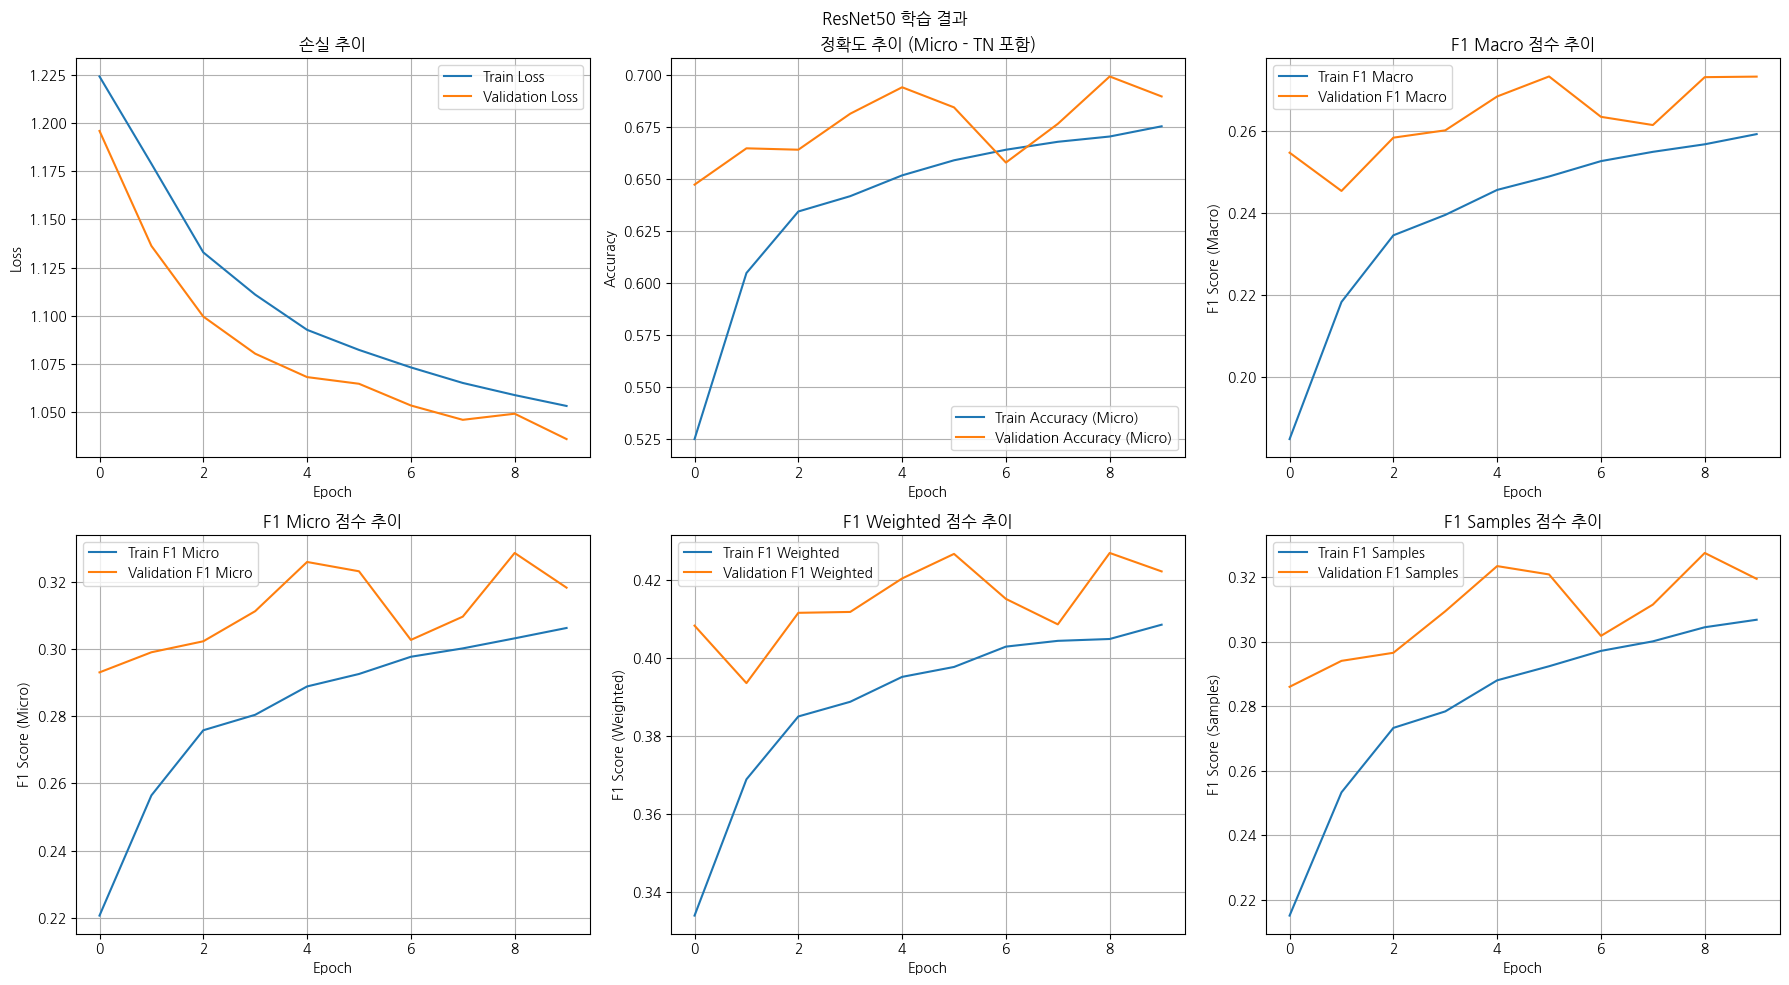


ResNet50 테스트 결과:
Loss: 1.0349

[멀티레이블 Accuracy 지표]

✗ ResNet50 학습 중 오류 발생: 'accuracy_micro'

[2/9] ViT 학습 시작...


Traceback (most recent call last):
  File "/tmp/ipykernel_4398/3775985770.py", line 168, in <module>
    print(f"  Accuracy (Micro, TN 포함):  {test_metrics['accuracy_micro']:.4f}")
KeyError: 'accuracy_micro'


학습 시작: ViT
Epoch 1/10


Training:   0%|          | 0/972 [00:00<?, ?it/s]

Validation:   0%|          | 0/163 [00:00<?, ?it/s]

Train Loss: 1.2109, Val Loss: 1.1589
Train Acc (micro): 0.5665, Val Acc (micro): 0.6709
Train F1 - Macro: 0.1893, Micro: 0.2270, Weighted: 0.3312, Samples: 0.2215
Val F1 - Macro: 0.2404, Micro: 0.2835, Weighted: 0.3741, Samples: 0.2797
--------------------------------------------------
Epoch 2/10


Training:   0%|          | 0/972 [00:00<?, ?it/s]

Validation:   0%|          | 0/163 [00:00<?, ?it/s]

Train Loss: 1.1245, Val Loss: 1.0721
Train Acc (micro): 0.6499, Val Acc (micro): 0.6705
Train F1 - Macro: 0.2370, Micro: 0.2824, Weighted: 0.3826, Samples: 0.2822
Val F1 - Macro: 0.2613, Micro: 0.3011, Weighted: 0.4087, Samples: 0.3054
--------------------------------------------------
Epoch 3/10


Training:   0%|          | 0/972 [00:00<?, ?it/s]

Validation:   0%|          | 0/163 [00:00<?, ?it/s]

Train Loss: 1.0666, Val Loss: 1.0315
Train Acc (micro): 0.6734, Val Acc (micro): 0.7053
Train F1 - Macro: 0.2567, Micro: 0.3045, Weighted: 0.4052, Samples: 0.3074
Val F1 - Macro: 0.2785, Micro: 0.3323, Weighted: 0.4319, Samples: 0.3386
--------------------------------------------------
Epoch 4/10


Training:   0%|          | 0/972 [00:00<?, ?it/s]

Validation:   0%|          | 0/163 [00:00<?, ?it/s]

Train Loss: 1.0320, Val Loss: 1.0093
Train Acc (micro): 0.6906, Val Acc (micro): 0.7027
Train F1 - Macro: 0.2695, Micro: 0.3194, Weighted: 0.4179, Samples: 0.3224
Val F1 - Macro: 0.2773, Micro: 0.3289, Weighted: 0.4268, Samples: 0.3333
--------------------------------------------------
Epoch 5/10


Training:   0%|          | 0/972 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [20]:
# 메모리 효율적인 실험 설정 및 모델 학습

import os
import torch
import pickle
from datetime import datetime

# 모델 저장 디렉토리 생성
os.makedirs('saved_models', exist_ok=True)

# ===================================================================
# pos_weight 계산 (클래스 불균형 대응)
# ===================================================================
print("클래스별 양성/음성 샘플 비율 계산 중...")

# Train split에서 클래스별 양성/음성 개수 계산
class_pos = np.zeros(len(SELECTED_GENRES), dtype=np.int64)
class_neg = np.zeros(len(SELECTED_GENRES), dtype=np.int64)

for mid in train_dataset.valid_ids:
    with open(os.path.join(DATASET_PATH, f"{mid}.json"), 'r') as f:
        genres = [g for g in json.load(f).get('genres', []) if g in genre_to_idx]
    
    # 라벨 벡터 생성
    y = np.zeros(len(SELECTED_GENRES), dtype=np.int64)
    for g in genres:
        y[genre_to_idx[g]] = 1
    
    class_pos += y
    class_neg += (1 - y)

# pos_weight = N_neg / N_pos (0 분모 방지)
pos_weight_np = class_neg / np.clip(class_pos, 1, None)
pos_weight = torch.tensor(pos_weight_np, dtype=torch.float32, device=device)

print("\n클래스별 pos_weight 값:")
print(f"{'Genre':<20} {'Positive':>10} {'Negative':>10} {'pos_weight':>12}")
print("-" * 54)
for i, genre in enumerate(SELECTED_GENRES):
    print(f"{genre:<20} {class_pos[i]:>10} {class_neg[i]:>10} {pos_weight_np[i]:>12.4f}")
print(f"\npos_weight 평균: {pos_weight_np.mean():.4f}")
print(f"pos_weight 최대: {pos_weight_np.max():.4f} (가장 불균형한 클래스)")
print(f"pos_weight 최소: {pos_weight_np.min():.4f} (가장 균형잡힌 클래스)\n")

# 손실 함수 정의 (멀티 레이블 분류 + 클래스 불균형 보정)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

print("✓ BCEWithLogitsLoss에 pos_weight 적용 완료!")
print("  - 소수 클래스의 손실이 더 크게 반영되어 불균형 문제를 완화합니다.")
print("  - 'Drama', 'Comedy'와 같은 다수 클래스의 영향력이 줄어듭니다.\n")

# ===================================================================
# 학습 파라미터
# ===================================================================
num_epochs = 10
learning_rate = 2e-5
weight_decay = 1e-4

# 모델 결과 저장을 위한 딕셔너리
model_results = {}

# 학습할 모델 정의 (한 번에 하나씩 생성하여 메모리 절약)
models_config = {
    # 단일 모달 모델
    'ResNet50': {'type': 'single', 'modality': 'image', 'extractor': 'resnet50'},
    'ViT': {'type': 'single', 'modality': 'image', 'extractor': 'vit'},
    'BERT': {'type': 'single', 'modality': 'text', 'extractor': 'bert'},
    'RoBERTa': {'type': 'single', 'modality': 'text', 'extractor': 'roberta'},
    
    # 멀티모달 모델
    'EarlyFusion': {'type': 'multi', 'img_extractor': 'resnet50', 'text_extractor': 'bert', 'fusion_method': 'early'},
    'LateFusion': {'type': 'multi', 'img_extractor': 'resnet50', 'text_extractor': 'bert', 'fusion_method': 'late'},
    'AttentionFusion': {'type': 'multi', 'img_extractor': 'resnet50', 'text_extractor': 'bert', 'fusion_method': 'attention'},
    'CrossAttentionFusion': {'type': 'multi', 'img_extractor': 'resnet50', 'text_extractor': 'bert', 'fusion_method': 'cross-attention'},
    'GMU': {'type': 'multi', 'img_extractor': 'resnet50', 'text_extractor': 'bert', 'fusion_method': 'gmu'}  # 논문 A의 제안 모델
}

print(f"총 {len(models_config)}개의 모델을 순차적으로 학습합니다.")
print("각 모델 학습 후 메모리를 정리하여 OutOfMemory 오류를 방지합니다.\n")
print("=" * 80)

# 각 모델을 순차적으로 학습 (메모리 효율성을 위해)
for i, (model_name, config) in enumerate(models_config.items(), 1):
    print(f"\n[{i}/{len(models_config)}] {model_name} 학습 시작...")
    
    # 이전 모델 변수들 정리
    if 'model' in locals():
        del model
    if 'optimizer' in locals():
        del optimizer
    if 'scheduler' in locals():
        del scheduler
    clear_memory()
    
    try:
        # 모델 생성
        if config['type'] == 'single':
            model = SingleModalModel(
                num_classes=len(SELECTED_GENRES),
                modality=config['modality'],
                extractor=config['extractor'],
                freeze_extractor=True
            )
        else:  # 멀티모달
            model = MultimodalModel(
                num_classes=len(SELECTED_GENRES),
                img_extractor=config['img_extractor'],
                text_extractor=config['text_extractor'],
                fusion_method=config['fusion_method'],
                freeze_extractors=True
            )
        
        # 모델을 디바이스로 이동
        model = safe_model_to_device(model, device)
        
        # 옵티마이저 및 스케줄러 설정
        optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        # verbose 파라미터 제거 (최신 PyTorch에서는 지원하지 않음)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)
        
        # 학습 시작
        print(f"학습 시작: {model_name}")
        trained_model, history = train_model(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            criterion=criterion,  # pos_weight가 적용된 criterion
            optimizer=optimizer,
            scheduler=scheduler,
            num_epochs=num_epochs,
            device=device,
            early_stop_patience=5
        )
        
        # 테스트 평가
        print(f"\n{model_name} 테스트 평가 중...")
        test_metrics, test_preds, test_probs, test_targets = evaluate_model(
            model=trained_model,
            test_loader=test_loader,
            criterion=criterion,  # pos_weight가 적용된 criterion
            device=device
        )
        
        # 결과 저장
        model_results[model_name] = {
            'model': trained_model,
            'history': history,
            'test_metrics': test_metrics,
            'test_preds': test_preds,
            'test_probs': test_probs,
            'test_targets': test_targets
        }
        
        # 모델 파일 저장
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        model_path = os.path.join('saved_models', f'{model_name}_model_{timestamp}.pth')
        torch.save(trained_model.state_dict(), model_path)
        print(f"✓ 모델 저장 완료: {model_path}")
        
        # 학습 곡선 시각화
        plot_training_history(history, title=f'{model_name} 학습 결과')
        
        # 테스트 결과 출력 (논문 A 형식)
        print(f"\n{model_name} 테스트 결과:")
        print(f"{'='*80}")
        print(f"Loss: {test_metrics['loss']:.4f}")
        print(f"\n[멀티레이블 Accuracy 지표]")
        print(f"  Accuracy (Micro, TN 포함):  {test_metrics['accuracy_micro']:.4f}")
        print(f"  Subset Accuracy (정확 일치): {test_metrics['subset_accuracy']:.4f}")
        print(f"  Hamming Accuracy:           {test_metrics['hamming_accuracy']:.4f}")
        print(f"  Jaccard (Samples):          {test_metrics['jaccard_samples']:.4f}")
        
        print(f"\n[F1-Score - 논문 A의 주요 지표]")
        print(f"  F1 (Macro):                 {test_metrics['f1_macro']:.4f}")
        print(f"  F1 (Micro):                 {test_metrics['f1_micro']:.4f}")
        print(f"  F1 (Weighted):              {test_metrics['f1_weighted']:.4f}")
        print(f"  F1 (Samples):               {test_metrics['f1_samples']:.4f}")
        
        print(f"\n[Precision]")
        print(f"  Macro:    {test_metrics['precision_macro']:.4f}")
        print(f"  Micro:    {test_metrics['precision_micro']:.4f}")
        print(f"  Weighted: {test_metrics['precision_weighted']:.4f}")
        
        print(f"\n[Recall]")
        print(f"  Macro:    {test_metrics['recall_macro']:.4f}")
        print(f"  Micro:    {test_metrics['recall_micro']:.4f}")
        print(f"  Weighted: {test_metrics['recall_weighted']:.4f}")
        
        if not np.isnan(test_metrics.get('roc_auc', float('nan'))):
            print(f"\n[ROC-AUC]")
            print(f"  Macro: {test_metrics['roc_auc']:.4f}")
            print(f"  Micro: {test_metrics['roc_auc_micro']:.4f}")
        
        if not np.isnan(test_metrics.get('mAP', float('nan'))):
            print(f"\n[mAP (Mean Average Precision)]")
            print(f"  Macro: {test_metrics['mAP']:.4f}")
            print(f"  Micro: {test_metrics['mAP_micro']:.4f}")
        
        print(f"{'='*80}\n")
        
        # 장르별 성능 출력
        if 'per_genre_metrics' in test_metrics:
            print_per_genre_metrics(test_metrics['per_genre_metrics'], 
                                   title=f"{model_name} - 장르별 성능 지표")
        
        # 메모리 정리
        clear_memory()
        print(f"✓ {model_name} 학습 완료 및 메모리 정리됨\n")
        print("=" * 80)
        
    except Exception as e:
        print(f"\n✗ {model_name} 학습 중 오류 발생: {e}")
        import traceback
        traceback.print_exc()
        clear_memory()
        continue

print("\n" + "=" * 80)
print("모든 모델 학습이 완료되었습니다!")
print("=" * 80)

# 전체 결과 저장
results_path = 'saved_models/all_model_results.pkl'
with open(results_path, 'wb') as f:
    # 모델 객체는 제외하고 저장 (용량 문제)
    save_results = {
        name: {
            'history': result['history'],
            'test_metrics': result['test_metrics']
        }
        for name, result in model_results.items()
    }
    pickle.dump(save_results, f)

print(f"\n✓ 전체 실험 결과 저장 완료: {results_path}")

## 저장된 모델 불러오기 및 사용

In [37]:
# Cell 24에서 생성된 모델들을 불러오는 함수
def load_saved_model(model_path, device):
    """
    저장된 모델을 불러오는 함수
    
    Args:
        model_path (str): 저장된 모델 파일 경로
        device: PyTorch 디바이스
    
    Returns:
        tuple: (model, model_info)
    """
    # 저장된 데이터 로드 (PyTorch 2.6 호환성을 위해 weights_only=False 설정)
    try:
        # 먼저 weights_only=True로 시도
        checkpoint = torch.load(model_path, map_location=device, weights_only=True)
    except Exception as e:
        print(f"weights_only=True로 로딩 실패, weights_only=False로 재시도...")
        # 실패하면 weights_only=False로 재시도 (신뢰할 수 있는 파일인 경우)
        checkpoint = torch.load(model_path, map_location=device, weights_only=False)
    
    # 모델 설정 정보 추출
    model_config = checkpoint['model_config']
    model_name = model_config['model_name']
    
    print(f"모델 정보:")
    print(f"- 모델 이름: {model_name}")
    print(f"- 클래스 수: {model_config['num_classes']}")
    
    # 모델 재생성
    if model_name in ['ResNet50', 'ViT']:
        # 이미지 단일 모달 모델
        model = SingleModalModel(
            model_config['num_classes'], 
            modality='image', 
            extractor=model_name.lower()
        )
    elif model_name in ['BERT', 'RoBERTa']:
        # 텍스트 단일 모달 모델
        model = SingleModalModel(
            model_config['num_classes'], 
            modality='text', 
            extractor=model_name.lower()
        )
    else:
        # 멀티모달 모델
        img_extractor = model_config.get('img_extractor', 'resnet50')
        text_extractor = model_config.get('text_extractor', 'bert')
        fusion_method = model_config.get('fusion_method', 'early')
        freeze_extractors = model_config.get('freeze_extractors', False)
        
        model = MultimodalModel(
            model_config['num_classes'],
            img_extractor=img_extractor,
            text_extractor=text_extractor,
            fusion_method=fusion_method,
            freeze_extractors=freeze_extractors
        )
    
    # 모델을 디바이스로 이동
    model = model.to(device)
    
    # 저장된 가중치 로드
    model.load_state_dict(checkpoint['model_state_dict'])
    
    # 평가 모드로 설정
    model.eval()
    
    # 모델 정보 구성
    model_info = {
        'model_name': model_name,
        'config': model_config,
        'metrics': checkpoint.get('metrics', {}),
        'history': checkpoint.get('history', {}),
        'training_params': {
            'num_epochs': checkpoint.get('num_epochs', 'N/A'),
            'learning_rate': checkpoint.get('learning_rate', 'N/A'),
            'weight_decay': checkpoint.get('weight_decay', 'N/A')
        }
    }
    
    print(f"모델이 성공적으로 로드되었습니다!")
    
    # 성능 메트릭 출력
    if 'metrics' in checkpoint and checkpoint['metrics']:
        print(f"\n저장된 모델 성능:")
        for metric, value in checkpoint['metrics'].items():
            if isinstance(value, dict):
                # 딕셔너리인 경우 (per_genre_metrics 등)
                print(f"- {metric}: [장르별 메트릭 - 생략]")
            elif isinstance(value, (int, float)):
                print(f"- {metric}: {value:.4f}")
            else:
                print(f"- {metric}: {value}")
    
    return model, model_info

In [24]:
# 저장된 모델 파일 목록 확인
import glob

def list_saved_models():
    """저장된 모델 파일 목록을 보여주는 함수"""
    model_files = glob.glob('saved_models/*.pth')
    
    if not model_files:
        print("저장된 모델이 없습니다.")
        return []
    
    print("저장된 모델 목록:")
    for i, model_file in enumerate(model_files, 1):
        print(f"{i}. {model_file}")
    
    return model_files

# 저장된 모델 목록 확인
saved_models = list_saved_models()

저장된 모델 목록:
1. saved_models/ResNet50_model_20251017_093724.pth
2. saved_models/EarlyFusion_model_20251019_162607.pth
3. saved_models/ResNet50_model_20251017_021118.pth
4. saved_models/RoBERTa_model_20251018_222645.pth
5. saved_models/BERT_model_20251018_071307.pth
6. saved_models/AttentionFusion_model_20251021_042359.pth
7. saved_models/CrossAttentionFusion_model_20251021_222624.pth
8. saved_models/LateFusion_model_20251020_102444.pth
9. saved_models/BERT_model_20251017_050828.pth
10. saved_models/ViT_model_20251017_155430.pth
11. saved_models/ViT_model_20251017_030300.pth
12. saved_models/GMU_model_20251022_162657.pth


In [27]:
# 저장된 모델 불러오기 예시
# 아래 코드를 실행하기 전에 위의 셀에서 저장된 모델 목록을 확인하고
# model_path 변수에 불러올 모델의 경로를 입력하세요

# 예시: 가장 최근에 저장된 mini 모델 불러오기
if saved_models:
    # 가장 최근 파일 찾기 (파일명에 timestamp가 포함되어 있으므로)
    latest_model_path = max(saved_models, key=os.path.getctime)
    print(f"가장 최근 모델을 불러옵니다: {latest_model_path}")
    
    # 모델 불러오기
    loaded_model, model_info = load_saved_model(latest_model_path, device)
    
    print(f"\n모델 설정 정보:")
    print(f"- 훈련 에포크 수: {model_info['training_params']['num_epochs']}")
    print(f"- 학습률: {model_info['training_params']['learning_rate']}")
    
else:
    print("저장된 모델이 없습니다. 먼저 모델을 훈련하고 저장하세요.")

가장 최근 모델을 불러옵니다: saved_models/GMU_model_20251022_162657.pth
weights_only=True로 로딩 실패, weights_only=False로 재시도...
모델 정보:
- 모델 이름: GMU
- 클래스 수: 23
모델이 성공적으로 로드되었습니다!

저장된 모델 성능:
- loss: 0.1808
- accuracy: 0.9278
- precision_macro: 0.5671
- precision_micro: 0.7398
- precision_weighted: 0.6914
- recall_macro: 0.3298
- recall_micro: 0.5105
- recall_weighted: 0.5105
- f1_macro: 0.3947
- f1_micro: 0.6041
- f1_weighted: 0.5665
- f1_samples: 0.6060
- per_genre_metrics: [장르별 메트릭 - 생략]
- roc_auc: 0.9024
- roc_auc_micro: 0.9339
- mAP: 0.5434
- mAP_micro: 0.6996

모델 설정 정보:
- 훈련 에포크 수: 10
- 학습률: 2e-05


In [28]:
# 데이터셋 키 구조 확인하기
sample_data = test_dataset[0]
print("테스트 데이터셋에서 반환되는 키들:")
print(list(sample_data.keys()))

# 각 키의 정보 출력
for key, value in sample_data.items():
    if isinstance(value, torch.Tensor):
        print(f"- {key}: torch.Tensor (shape: {value.shape})")
    elif isinstance(value, dict):
        print(f"- {key}: dict with keys: {list(value.keys())}")
    else:
        print(f"- {key}: {type(value).__name__} - {str(value)[:50]}{'...' if len(str(value)) > 50 else ''}")

print(f"\n영화 ID: {sample_data['movie_id']}")
print(f"DATASET_PATH: {DATASET_PATH}")

# 이미지 경로 구성하기
movie_id = sample_data['movie_id']
image_path = os.path.join(DATASET_PATH, f"{movie_id}.jpeg")
print(f"구성된 이미지 경로: {image_path}")
print(f"이미지 파일 존재 여부: {os.path.exists(image_path)}")

테스트 데이터셋에서 반환되는 키들:
['image', 'text', 'labels', 'movie_id', 'plot']
- image: torch.Tensor (shape: torch.Size([3, 224, 224]))
- text: dict with keys: ['input_ids', 'attention_mask']
- labels: torch.Tensor (shape: torch.Size([23]))
- movie_id: str - 0023268
- plot: str - Judge Moffett is as crooked as they come and the B...

영화 ID: 0023268
DATASET_PATH: /home/mingky/workspace/mmimdb_test/data/mmimdb/dataset
구성된 이미지 경로: /home/mingky/workspace/mmimdb_test/data/mmimdb/dataset/0023268.jpeg
이미지 파일 존재 여부: True


In [38]:
# 모델을 불러와서 추론 수행

import glob
import os

# 생성된 모델 파일들 확인
model_files = glob.glob('saved_models/*_model_*.pth')

if not model_files:
    print("생성된 모델 파일이 없습니다. 모델을 먼저 학습하세요.")
else:
    print(f"생성된 모델 파일들:")
    for model_file in sorted(model_files):
        model_name = os.path.basename(model_file).split('_model_')[0]
        print(f"- {model_name}: {model_file}")
    
    # 최고 성능 모델이 있으면 해당 모델 사용, 없으면 첫 번째 모델 사용
    if 'best_model_name' in globals() and best_model_name:
        # 최고 성능 모델 파일 찾기
        best_model_files = [f for f in model_files if best_model_name in f]
        if best_model_files:
            selected_model_path = best_model_files[0]
            print(f"\n최고 성능 모델을 사용합니다: {best_model_name}")
        else:
            selected_model_path = model_files[0]
            print(f"\n최고 성능 모델 파일을 찾을 수 없어서 첫 번째 모델을 사용합니다.")
    else:
        selected_model_path = model_files[0]
        print(f"\n첫 번째 모델을 사용합니다.")
    
    print(f"선택된 모델: {selected_model_path}")
    
    # 선택된 모델 불러오기
    inference_model, model_info = load_saved_model(selected_model_path, device)
    
    if inference_model is not None:
        print(f"\n모델 로드 성공! 추론을 시작합니다.")
        
        # 테스트 데이터가 없으면 생성
        if 'test_loader' not in globals() or test_loader is None:
            print("test_loader를 생성합니다...")
            test_loader = DataLoader(
                test_dataset, 
                batch_size=16, 
                shuffle=False, 
                num_workers=2
            )
            print("test_loader 생성 완료")
        
        # 모델 평가
        print("\n모델 평가를 수행합니다...")
        inference_metrics, inference_preds, inference_probs, inference_targets = evaluate_model(
            inference_model, test_loader, criterion, device
        )
        
        # 결과 출력 (저장된 ROC-AUC 우선 표시)
        print(f"\n{model_info['model_name']} 모델 평가 결과:")
        
        # 1. 먼저 저장된 메트릭 표시
        saved_metrics = model_info.get('metrics', {})
        if saved_metrics and ('roc_auc' in saved_metrics or 'roc_auc_micro' in saved_metrics):
            print("  [저장된 ROC-AUC 정보]")
            if 'roc_auc' in saved_metrics:
                roc_auc_val = saved_metrics['roc_auc']
                if isinstance(roc_auc_val, (int, float)) and not np.isnan(roc_auc_val):
                    print(f"  roc_auc (macro): {roc_auc_val:.4f}")
                else:
                    print(f"  roc_auc (macro): {roc_auc_val}")
            
            if 'roc_auc_micro' in saved_metrics:
                roc_auc_micro_val = saved_metrics['roc_auc_micro']
                if isinstance(roc_auc_micro_val, (int, float)) and not np.isnan(roc_auc_micro_val):
                    print(f"  roc_auc (micro): {roc_auc_micro_val:.4f}")
                else:
                    print(f"  roc_auc (micro): {roc_auc_micro_val}")
        
        # 2. 새로 계산한 메트릭 표시
        print("  [새로 계산한 메트릭]")
        for metric, value in inference_metrics.items():
            if isinstance(value, (int, float)) and not np.isnan(value):
                print(f"  {metric}: {value:.4f}")
            else:
                print(f"  {metric}: {value}")
        
        # 샘플 예측 결과 시각화 함수
        def show_sample_predictions(model, test_loader, num_samples=3):
            """테스트 샘플에 대한 예측 결과를 시각화합니다."""
            model.eval()
            
            samples_shown = 0
            
            with torch.no_grad():
                for batch in test_loader:
                    if samples_shown >= num_samples:
                        break
                    
                    images = batch['image'].to(device)
                    if 'text' in batch:
                        text_inputs = {
                            'input_ids': batch['text']['input_ids'].to(device),
                            'attention_mask': batch['text']['attention_mask'].to(device)
                        }
                    else:
                        text_inputs = None
                    
                    targets = batch['labels']
                    movie_ids = batch['movie_id']
                    plots = batch['plot']
                    
                    # 모델 추론
                    if text_inputs and hasattr(model, 'img_extractor') and hasattr(model, 'text_extractor'):
                        # 멀티모달 모델
                        outputs = model(images, text_inputs)
                    elif hasattr(model, 'modality'):
                        # 단일 모달 모델
                        if model.modality == 'image':
                            outputs = model(images)
                        else:  # text modality
                            outputs = model(text_inputs)
                    else:
                        outputs = model(images)
                    
                    probs = torch.sigmoid(outputs).cpu().numpy()
                    
                    for i in range(min(len(images), num_samples - samples_shown)):
                        # 예측 결과 분석
                        sample_probs = probs[i]
                        sample_targets = targets[i].numpy()
                        
                        # 상위 5개 예측 장르
                        top_5_indices = np.argsort(sample_probs)[-5:][::-1]
                        
                        print(f"\n=== 샘플 {samples_shown + 1} (Movie ID: {movie_ids[i]}) ===")
                        print(f"줄거리: {plots[i][:100]}...")
                        
                        # 실제 장르
                        true_genres = [SELECTED_GENRES[j] for j in range(len(sample_targets)) if sample_targets[j] > 0.5]
                        print(f"실제 장르: {', '.join(true_genres)}")
                        
                        print(f"예측 장르 (상위 5개):")
                        for j, idx in enumerate(top_5_indices):
                            genre = SELECTED_GENRES[idx]
                            prob = sample_probs[idx]
                            is_correct = "✓" if sample_targets[idx] > 0.5 else "✗"
                            print(f"  {j+1}. {genre}: {prob:.3f} {is_correct}")
                        
                        samples_shown += 1
                        
                        if samples_shown >= num_samples:
                            break
        
        # 샘플 예측 결과 출력
        print(f"\n샘플 예측 결과:")
        show_sample_predictions(inference_model, test_loader, num_samples=3)
        
    else:
        print("모델 로드에 실패했습니다.")

생성된 모델 파일들:
- AttentionFusion: saved_models/AttentionFusion_model_20251021_042359.pth
- BERT: saved_models/BERT_model_20251017_050828.pth
- BERT: saved_models/BERT_model_20251018_071307.pth
- CrossAttentionFusion: saved_models/CrossAttentionFusion_model_20251021_222624.pth
- EarlyFusion: saved_models/EarlyFusion_model_20251019_162607.pth
- GMU: saved_models/GMU_model_20251022_162657.pth
- LateFusion: saved_models/LateFusion_model_20251020_102444.pth
- ResNet50: saved_models/ResNet50_model_20251017_021118.pth
- ResNet50: saved_models/ResNet50_model_20251017_093724.pth
- RoBERTa: saved_models/RoBERTa_model_20251018_222645.pth
- ViT: saved_models/ViT_model_20251017_030300.pth
- ViT: saved_models/ViT_model_20251017_155430.pth

최고 성능 모델을 사용합니다: CrossAttentionFusion
선택된 모델: saved_models/CrossAttentionFusion_model_20251021_222624.pth
weights_only=True로 로딩 실패, weights_only=False로 재시도...
weights_only=True로 로딩 실패, weights_only=False로 재시도...
모델 정보:
- 모델 이름: CrossAttentionFusion
- 클래스 수: 23
모델 정보:

Evaluating:   0%|          | 0/488 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [29]:
# 생성된 모델을 사용한 추가 분석

# 이전 셀에서 로드한 inference_model을 사용
if 'inference_model' in globals() and inference_model is not None:
    print(f"사용 모델: {model_info['model_name']}")
    
    # 테스트 세트에서 예측 결과 시각화
    def visualize_predictions(model, test_loader, genre_list, num_samples=3):
        """테스트 샘플에 대한 예측 결과 시각화"""
        model.eval()
        
        samples = []
        predictions = []
        true_labels = []
        
        with torch.no_grad():
            for batch in test_loader:
                # 이미 충분한 샘플을 얻었으면 종료
                if len(samples) >= num_samples:
                    break
                
                images = batch['image'].to(device)
                
                # 멀티모달 모델인 경우 텍스트 입력도 처리
                if hasattr(model, 'text_extractor') and 'text' in batch:
                    text_inputs = {
                        'input_ids': batch['text']['input_ids'].to(device),
                        'attention_mask': batch['text']['attention_mask'].to(device)
                    }
                    outputs = model(images, text_inputs)
                else:
                    # 단일 모달 이미지 모델
                    outputs = model(images)
                
                targets = batch['labels']
                probs = torch.sigmoid(outputs).cpu().numpy()
                
                for i in range(len(images)):
                    if len(samples) >= num_samples:
                        break
                    
                    samples.append(images[i].cpu())
                    predictions.append(probs[i])
                    true_labels.append(targets[i])
        
        # 결과 시각화
        fig, axes = plt.subplots(num_samples, 2, figsize=(16, 5*num_samples))
        if num_samples == 1:
            axes = axes.reshape(1, -1)
        
        for i, (sample, pred, true) in enumerate(zip(samples, predictions, true_labels)):
            # 이미지 표시
            img = sample.numpy().transpose(1, 2, 0)
            img = (img * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]  # 정규화 복원
            img = np.clip(img, 0, 1)
            
            axes[i, 0].imshow(img)
            axes[i, 0].set_title('영화 포스터')
            axes[i, 0].axis('off')
            
            # 상위 5개 장르 예측 결과 시각화
            pred_indices = np.argsort(pred)[-5:][::-1]
            pred_scores = pred[pred_indices]
            pred_genres = [SELECTED_GENRES[idx] for idx in pred_indices]
            
            # 실제 장르
            true_indices = torch.where(true > 0.5)[0]
            true_genres = [SELECTED_GENRES[idx] for idx in true_indices]
            
            # 막대 그래프
            bars = axes[i, 1].barh(pred_genres, pred_scores, color='skyblue')
            axes[i, 1].set_xlim(0, 1)
            axes[i, 1].set_xlabel('확률')
            axes[i, 1].set_title(f'예측 장르 (실제: {", ".join(true_genres)})')
            axes[i, 1].grid(axis='x', linestyle='--', alpha=0.6)
            
            # 실제 장르에 빨간색 표시
            for j, genre in enumerate(pred_genres):
                if genre in true_genres:
                    bars[j].set_color('red')
                    bars[j].set_alpha(0.8)
            
            # 확률 값 표시
            for j, v in enumerate(pred_scores):
                axes[i, 1].text(v + 0.01, j, f'{v:.2f}', va='center')
        
        plt.tight_layout()
        plt.show()
    
    # 테스트 샘플 예측 결과 시각화
    print(f"\n{model_info['model_name']} 모델의 예측 결과 시각화:")
    visualize_predictions(inference_model, test_loader, SELECTED_GENRES, num_samples=3)
    
else:
    print("먼저 이전 셀에서 모델을 로드하세요.")

먼저 이전 셀에서 모델을 로드하세요.


In [30]:
# 생성된 모델을 사용한 Grad-CAM 시각화

# Grad-CAM 시각화
if 'inference_model' in globals() and inference_model is not None:
    print(f"Grad-CAM 시각화를 위해 {model_info['model_name']} 모델을 사용합니다.")
    
    def visualize_gradcam_with_saved_model(model, test_loader, genre_list, num_samples=1):
        """저장된 모델을 사용한 Grad-CAM 시각화"""
        model.eval()
        
        # 모델이 멀티모달이고 이미지 특징 추출기가 ResNet50인 경우에만 Grad-CAM 실행
        grad_cam = None
        
        try:
            if (hasattr(model, 'img_extractor') and 
                hasattr(model.img_extractor, 'feature_extractor') and
                model.img_extractor.feature_extractor == 'resnet50'):
                
                # ResNet50의 마지막 Conv2d 레이어를 타겟으로 설정
                target_layer = None
                for name, module in model.img_extractor.model.named_modules():
                    if isinstance(module, torch.nn.Conv2d):
                        target_layer = module  # 마지막 Conv2d 레이어를 계속 업데이트
                
                if target_layer is not None:
                    print(f"Target layer for Grad-CAM: {target_layer}")
                    grad_cam = GradCAM(model, target_layer)
                else:
                    print("No suitable Conv2d layer found for Grad-CAM")
                    return
            else:
                print(f"{model_info['model_name']} 모델은 Grad-CAM 시각화를 지원하지 않습니다 (ResNet50 기반 멀티모달 모델만 지원)")
                return
                
            # 샘플 가져오기
            samples = []
            targets = []
            plots = []
            movie_ids = []
            
            with torch.no_grad():
                for batch in test_loader:
                    if len(samples) >= num_samples:
                        break
                        
                    images = batch['image']
                    movie_ids_batch = batch['movie_id']
                    plot_texts = batch['plot']
                    
                    for i in range(len(images)):
                        if len(samples) >= num_samples:
                            break
                            
                        samples.append(images[i])
                        targets.append(batch['labels'][i])
                        plots.append(plot_texts[i])
                        movie_ids.append(movie_ids_batch[i])
            
            # Grad-CAM 시각화
            for i, (sample, target, plot_text, movie_id) in enumerate(zip(samples, targets, plots, movie_ids)):
                # 이미지 정규화 복원
                img = sample.numpy().transpose(1, 2, 0)
                img = (img * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]
                img = np.clip(img, 0, 1)
                
                # 실제 장르
                true_indices = torch.where(target > 0.5)[0]
                true_genres = [SELECTED_GENRES[idx] for idx in true_indices]
                
                print(f"Processing movie {movie_id}: {len(true_indices)} genres - {', '.join(true_genres)}")
                
                if len(true_indices) == 0:
                    print(f"No genres found for movie {movie_id}, skipping Grad-CAM visualization")
                    continue
                
                # 각 장르에 대한 Grad-CAM 시각화
                num_plots = min(len(true_indices) + 1, 6)  # 최대 6개 플롯으로 제한
                fig, axes = plt.subplots(1, num_plots, figsize=(5 * num_plots, 5))
                
                # axes가 단일 값인 경우를 처리
                if num_plots == 1:
                    axes = [axes]
                elif not isinstance(axes, (list, np.ndarray)):
                    axes = [axes]
                
                # 원본 이미지 표시
                axes[0].imshow(img)
                axes[0].set_title(f'원본 포스터\\n(ID: {movie_id})')
                axes[0].axis('off')
                
                # 각 실제 장르에 대한 Grad-CAM 시각화 (최대 5개까지)
                for j, idx in enumerate(true_indices[:5]):  # 최대 5개 장르만 시각화
                    try:
                        print(f"  Computing Grad-CAM for genre: {true_genres[j]} (index: {idx.item()})")
                        
                        # Grad-CAM 계산
                        img_tensor = sample.unsqueeze(0).to(device)
                        cam = grad_cam(img_tensor, class_idx=idx.item())
                        
                        # CAM이 유효한지 확인
                        if cam is not None and cam.max() > 0:
                            # 원본 이미지와 히트맵 합치기
                            heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
                            heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB) / 255.0
                            superimposed_img = 0.6 * img + 0.4 * heatmap
                            superimposed_img = np.clip(superimposed_img, 0, 1)
                            
                            # 시각화
                            axes[j + 1].imshow(superimposed_img)
                            axes[j + 1].set_title(f'장르: {true_genres[j]}')
                        else:
                            # Grad-CAM 실패시 원본 이미지 표시
                            axes[j + 1].imshow(img)
                            axes[j + 1].set_title(f'장르: {true_genres[j]}\\n(Grad-CAM 실패)')
                        
                        axes[j + 1].axis('off')
                        
                    except Exception as e:
                        print(f"    Error computing Grad-CAM for {true_genres[j]}: {e}")
                        # 에러 발생시 원본 이미지 표시
                        axes[j + 1].imshow(img)
                        axes[j + 1].set_title(f'장르: {true_genres[j]}\\n(에러 발생)')
                        axes[j + 1].axis('off')
                
                plt.suptitle(f'Grad-CAM 시각화: 장르별 중요 영역 ({model_info["model_name"]})')
                plt.tight_layout()
                plt.show()
                
                # 줄거리 출력
                print(f"줄거리: {plot_text[:200]}...")
                
        except Exception as e:
            print(f"Grad-CAM 시각화 중 오류 발생: {e}")
            print("Grad-CAM 시각화를 건너뜁니다.")
    
    # Grad-CAM 시각화 실행
    if 'GradCAM' in globals():  # GradCAM 클래스가 정의되어 있는 경우에만 실행
        visualize_gradcam_with_saved_model(inference_model, test_loader, SELECTED_GENRES, num_samples=1)
    else:
        print("GradCAM 클래스가 정의되지 않았습니다. 이전 셀에서 GradCAM 클래스를 정의하세요.")
        
else:
    print("먼저 이전 셀에서 모델을 로드하세요.")

먼저 이전 셀에서 모델을 로드하세요.


In [31]:
# 생성된 모델의 구조 확인 및 검증

if 'inference_model' in globals() and inference_model is not None:
    print(f"=== {model_info['model_name']} 모델 구조 확인 ===")
    print("Model type:", type(inference_model))
    
    # 모델 타입에 따른 구조 확인
    if hasattr(inference_model, 'img_extractor'):
        print(f"이미지 특징 추출기: {inference_model.img_extractor.feature_extractor}")
        print("Image extractor type:", type(inference_model.img_extractor.model))
        
        # ResNet50의 경우 마지막 컨볼루션 레이어 찾기
        if inference_model.img_extractor.feature_extractor == 'resnet50':
            print("\\n=== ResNet50 마지막 Conv2d 레이어 찾기 ===")
            last_conv_layers = []
            for name, module in inference_model.img_extractor.model.named_modules():
                if isinstance(module, torch.nn.Conv2d):
                    last_conv_layers.append((name, module))
            
            if len(last_conv_layers) > 0:
                print(f"Total Conv2d layers: {len(last_conv_layers)}")
                print("Last Conv2d layer:")
                name, layer = last_conv_layers[-1]
                print(f"  Name: {name}")
                print(f"  Layer: {layer}")
                print(f"  Output channels: {layer.out_channels}")
                
                # 이 레이어를 타겟으로 사용 (Grad-CAM용)
                target_layer = layer
                print(f"\\nGrad-CAM 타겟 레이어: {name}")
            else:
                print("No Conv2d layers found")
        elif inference_model.img_extractor.feature_extractor == 'vit':
            print("\\n=== Vision Transformer 구조 확인 ===")
            print("ViT 모델은 Grad-CAM 대신 Attention Map을 사용할 수 있습니다.")
    
    if hasattr(inference_model, 'text_extractor'):
        print(f"\\n텍스트 특징 추출기: {inference_model.text_extractor.feature_extractor}")
        print("Text extractor type:", type(inference_model.text_extractor.model))
    
    # 단일 모달 모델인 경우
    if hasattr(inference_model, 'modality'):
        print(f"\\n단일 모달 모델: {inference_model.modality}")
        print(f"특징 추출기: {inference_model.feature_extractor}")
    
    # 모델 파라미터 수 확인
    total_params = sum(p.numel() for p in inference_model.parameters())
    trainable_params = sum(p.numel() for p in inference_model.parameters() if p.requires_grad)
    
    print(f"\\n=== 모델 파라미터 정보 ===")
    print(f"전체 파라미터 수: {total_params:,}")
    print(f"학습 가능한 파라미터 수: {trainable_params:,}")
    print(f"동결된 파라미터 수: {total_params - trainable_params:,}")
    
    # 모델 성능 정보 출력
    if 'metrics' in model_info and model_info['metrics']:
        print(f"\\n=== {model_info['model_name']} 성능 지표 ===")
        for metric, value in model_info['metrics'].items():
            if isinstance(value, dict):
                # 딕셔너리인 경우 (per_genre_metrics 등)
                print(f"{metric}: [장르별 메트릭 - 생략]")
            elif isinstance(value, (int, float)):
                print(f"{metric}: {value:.4f}")
            else:
                print(f"{metric}: {value}")
    
else:
    print("먼저 이전 셀에서 모델을 로드하세요.")

먼저 이전 셀에서 모델을 로드하세요.


=== 저장된 모델 성능 메트릭 로드 ===
✅ AttentionFusion: 메트릭 로드 완료
✅ BERT: 메트릭 로드 완료
✅ BERT: 메트릭 로드 완료
✅ CrossAttentionFusion: 메트릭 로드 완료
✅ EarlyFusion: 메트릭 로드 완료
✅ GMU: 메트릭 로드 완료
✅ LateFusion: 메트릭 로드 완료
✅ ResNet50: 메트릭 로드 완료
✅ ResNet50: 메트릭 로드 완료
✅ RoBERTa: 메트릭 로드 완료
✅ ViT: 메트릭 로드 완료
✅ ViT: 메트릭 로드 완료

=== 전체 성능 비교 그래프 생성 ===


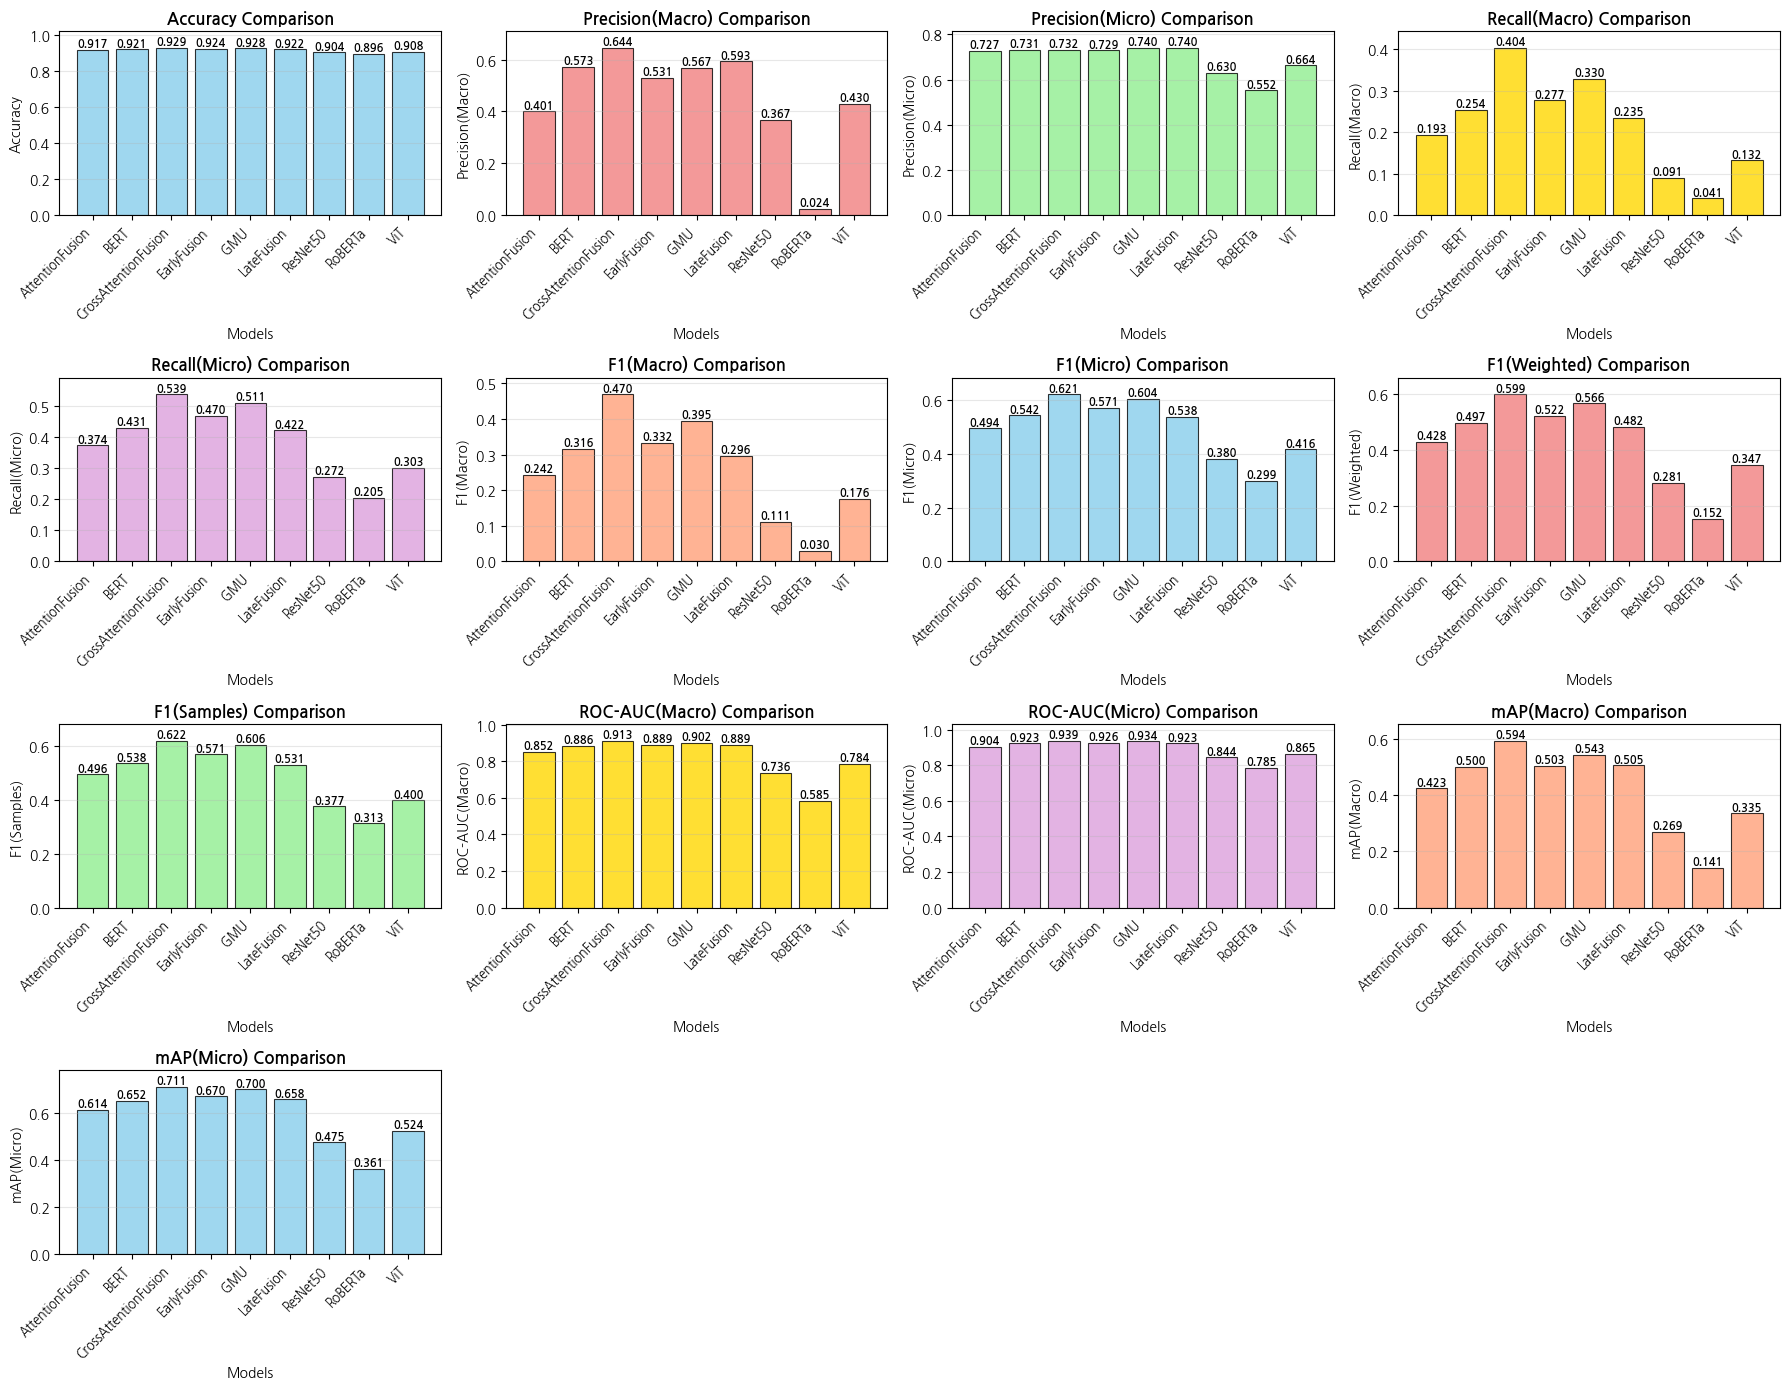

\n=== 종합 성능 레이더 차트 ===


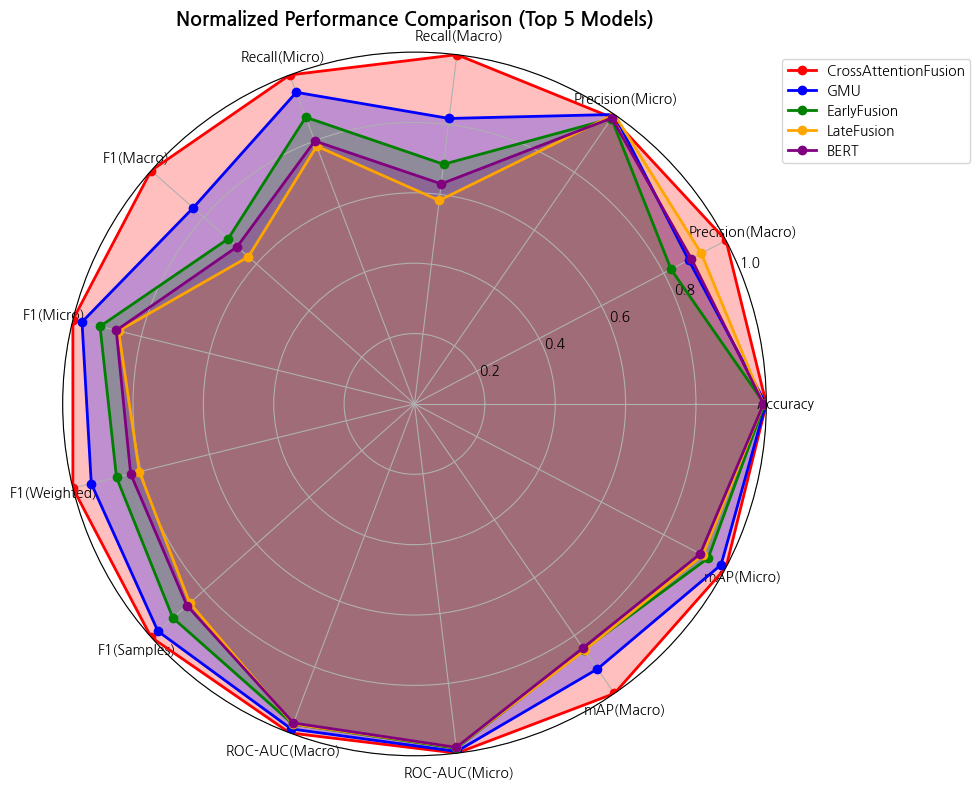


=== 주요 메트릭별 최고 성능 모델 ===
----------------------------------------------------------------------------------------------------

Accuracy:
  1. CrossAttentionFusion: 0.9290
  2. GMU                 : 0.9278
  3. EarlyFusion         : 0.9240

F1-Score (Macro):
  1. CrossAttentionFusion: 0.4696
  2. GMU                 : 0.3947
  3. EarlyFusion         : 0.3323

F1-Score (Micro):
  1. CrossAttentionFusion: 0.6207
  2. GMU                 : 0.6041
  3. EarlyFusion         : 0.5714

ROC-AUC (Macro):
  1. CrossAttentionFusion: 0.9135
  2. GMU                 : 0.9024
  3. EarlyFusion         : 0.8895

mAP (Macro):
  1. CrossAttentionFusion: 0.5936
  2. GMU                 : 0.5434
  3. LateFusion          : 0.5051
----------------------------------------------------------------------------------------------------

=== 단일 모달 vs 멀티모달 종합 성능 비교 ===


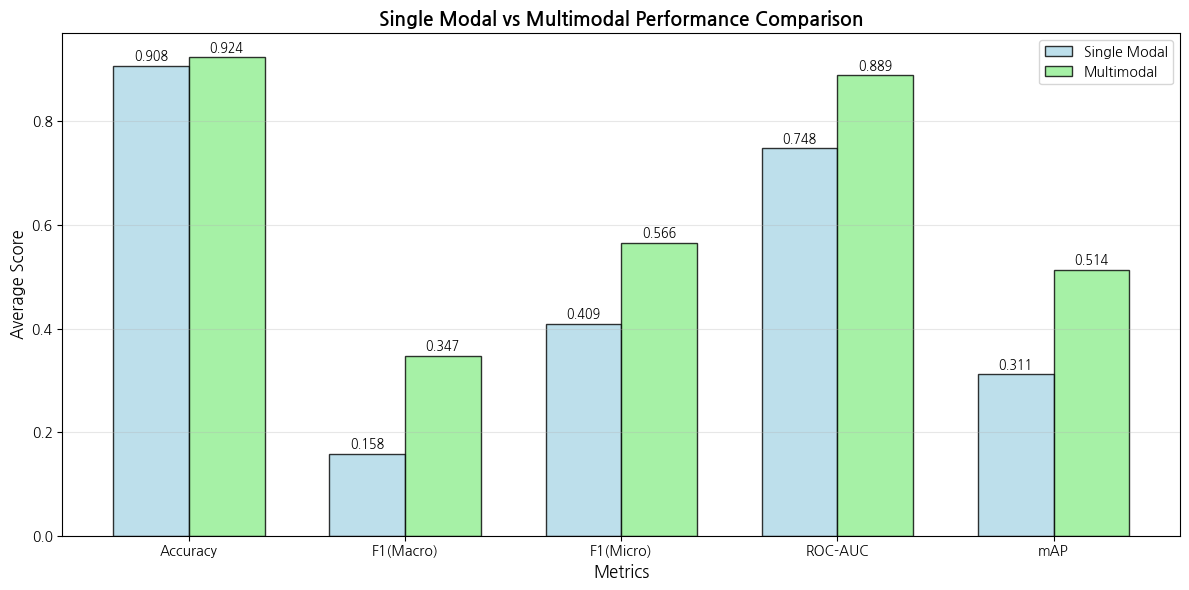


단일 모달 모델 (4개): ['BERT', 'ResNet50', 'RoBERTa', 'ViT']
멀티모달 모델 (5개): ['AttentionFusion', 'CrossAttentionFusion', 'EarlyFusion', 'GMU', 'LateFusion']

평균 성능 비교:
--------------------------------------------------------------------------------
Metric          Single Modal    Multimodal      Improvement    
--------------------------------------------------------------------------------
Accuracy        0.9076          0.9240          +1.81%
F1(Macro)       0.1583          0.3470          +119.20%
F1(Micro)       0.4091          0.5656          +38.26%
ROC-AUC         0.7478          0.8893          +18.91%
mAP             0.3113          0.5138          +65.01%
--------------------------------------------------------------------------------
\n=== 전체 모델 성능 요약 테이블 ===
Model                Accuracy   P(Macro)   R(Macro)   F1(Macro)  F1(Micro)  F1(Weighted) ROC-AUC    mAP       
AttentionFusion      0.9173     0.4007     0.1934     0.2423     0.4941     0.4279       0.8520     0.4233    
BERT 

In [ ]:
# 생성된 모델들의 결과 비교 및 종합 분석 (논문 A 형식 + 멀티레이블 지표)

import glob
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

print("=" * 100)
print("저장된 모델 성능 메트릭 분석 (논문 A Table 2 형식 + 멀티레이블 지표)")
print("=" * 100)

# model_results에서 직접 메트릭 추출
if 'model_results' in locals() and model_results:
    print("\n✓ model_results에서 메트릭을 직접 사용합니다.\n")
    
    # 데이터프레임으로 정리 (논문 A의 Table 2 형식)
    results_df = []
    
    for model_name, result in model_results.items():
        metrics = result['test_metrics']
        
        row = {
            'Model': model_name,
            # 멀티레이블 Accuracy 지표
            'Acc(Micro)': metrics.get('accuracy_micro', 0),
            'Subset Acc': metrics.get('subset_accuracy', 0),
            'Hamming Acc': metrics.get('hamming_accuracy', 0),
            'Jaccard': metrics.get('jaccard_samples', 0),
            # F1-Scores (논문 A의 주요 지표)
            'F1(Macro)': metrics.get('f1_macro', 0),
            'F1(Micro)': metrics.get('f1_micro', 0),
            'F1(Weighted)': metrics.get('f1_weighted', 0),
            'F1(Samples)': metrics.get('f1_samples', 0),
            # Precision
            'Prec(Macro)': metrics.get('precision_macro', 0),
            'Prec(Micro)': metrics.get('precision_micro', 0),
            # Recall
            'Rec(Macro)': metrics.get('recall_macro', 0),
            'Rec(Micro)': metrics.get('recall_micro', 0),
            # 보조 지표
            'ROC-AUC': metrics.get('roc_auc', 0),
            'mAP': metrics.get('mAP', 0)
        }
        results_df.append(row)
    
    df = pd.DataFrame(results_df)
    
    # F1(Macro)로 정렬 (논문 A의 주요 지표)
    df = df.sort_values('F1(Macro)', ascending=False)
    
    print("\n" + "=" * 100)
    print("전체 모델 성능 비교 (논문 A Table 2 형식 확장)")
    print("=" * 100)
    print(df.to_string(index=False))
    print("\n")
    
    # 주요 발견사항 출력
    print("=" * 100)
    print("주요 발견사항 및 분석")
    print("=" * 100)
    
    best_f1_macro = df.iloc[0]
    print(f"\n1. 최고 성능 모델 (F1 Macro 기준):")
    print(f"   모델: {best_f1_macro['Model']}")
    print(f"   F1(Macro): {best_f1_macro['F1(Macro)']:.4f}")
    print(f"   F1(Micro): {best_f1_macro['F1(Micro)']:.4f}")
    print(f"   F1(Weighted): {best_f1_macro['F1(Weighted)']:.4f}")
    print(f"   F1(Samples): {best_f1_macro['F1(Samples)']:.4f}")
    
    print(f"\n2. Accuracy vs F1-Score 차이 분석:")
    for _, row in df.iterrows():
        acc_f1_diff = row['Acc(Micro)'] - row['F1(Macro)']
        print(f"   {row['Model']:<25} Acc(Micro): {row['Acc(Micro)']:.4f}  |  F1(Macro): {row['F1(Macro)']:.4f}  |  차이: {acc_f1_diff:+.4f}")
    
    print(f"\n   → Accuracy(Micro)가 F1(Macro)보다 높은 이유:")
    print(f"     • Accuracy는 True Negative(TN)를 포함하여 계산")
    print(f"     • 멀티레이블 문제에서 대부분의 라벨은 0(부재)이므로 TN이 많음")
    print(f"     • F1은 TN을 제외하고 TP/FP/FN만 고려하여 실제 성능을 더 정확히 반영")
    
    print(f"\n3. 멀티레이블 전용 지표:")
    avg_subset = df['Subset Acc'].mean()
    avg_hamming = df['Hamming Acc'].mean()
    avg_jaccard = df['Jaccard'].mean()
    print(f"   평균 Subset Accuracy (정확 일치):  {avg_subset:.4f}")
    print(f"   평균 Hamming Accuracy:            {avg_hamming:.4f}")
    print(f"   평균 Jaccard (Samples):           {avg_jaccard:.4f}")
    print(f"   → Subset Accuracy가 낮은 것은 정상 (모든 라벨 완전 일치 필요)")
    
    # GMU 모델(논문 A의 제안) 성능 강조
    if 'GMU' in df['Model'].values:
        gmu_row = df[df['Model'] == 'GMU'].iloc[0]
        print(f"\n4. GMU 모델 (논문 A 제안):")
        print(f"   F1(Macro):    {gmu_row['F1(Macro)']:.4f}")
        print(f"   F1(Micro):    {gmu_row['F1(Micro)']:.4f}")
        print(f"   F1(Weighted): {gmu_row['F1(Weighted)']:.4f}")
        print(f"   F1(Samples):  {gmu_row['F1(Samples)']:.4f}")
    
    print("\n" + "=" * 100)
    
    # 시각화 1: F1-Scores 4종 비교 (논문 A의 주요 지표)
    print("\n[그래프 1] F1-Score 4종 비교 (논문 A Table 2)")
    
    fig, ax = plt.subplots(figsize=(14, 7))
    
    x = np.arange(len(df))
    width = 0.2
    
    ax.bar(x - 1.5*width, df['F1(Macro)'], width, label='F1(Macro)', alpha=0.8, color='#FF6B6B')
    ax.bar(x - 0.5*width, df['F1(Micro)'], width, label='F1(Micro)', alpha=0.8, color='#4ECDC4')
    ax.bar(x + 0.5*width, df['F1(Weighted)'], width, label='F1(Weighted)', alpha=0.8, color='#45B7D1')
    ax.bar(x + 1.5*width, df['F1(Samples)'], width, label='F1(Samples)', alpha=0.8, color='#FFA07A')
    
    ax.set_xlabel('Models', fontsize=12, fontweight='bold')
    ax.set_ylabel('F1-Score', fontsize=12, fontweight='bold')
    ax.set_title('F1-Score 4종 비교 (논문 A의 Table 2 지표)', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(df['Model'], rotation=45, ha='right')
    ax.legend(fontsize=10)
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim(0, 1.0)
    
    plt.tight_layout()
    plt.show()
    
    # 시각화 2: Accuracy 지표 비교
    print("\n[그래프 2] Accuracy 지표 비교 (멀티레이블 전용)")
    
    fig, ax = plt.subplots(figsize=(14, 7))
    
    x = np.arange(len(df))
    width = 0.22
    
    ax.bar(x - 1.5*width, df['Acc(Micro)'], width, label='Acc(Micro) - TN포함', alpha=0.8, color='#95E1D3')
    ax.bar(x - 0.5*width, df['Subset Acc'], width, label='Subset Acc - 정확일치', alpha=0.8, color='#F38181')
    ax.bar(x + 0.5*width, df['Hamming Acc'], width, label='Hamming Acc', alpha=0.8, color='#AA96DA')
    ax.bar(x + 1.5*width, df['Jaccard'], width, label='Jaccard(Samples)', alpha=0.8, color='#FCBAD3')
    
    ax.set_xlabel('Models', fontsize=12, fontweight='bold')
    ax.set_ylabel('Accuracy Score', fontsize=12, fontweight='bold')
    ax.set_title('멀티레이블 Accuracy 지표 비교', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(df['Model'], rotation=45, ha='right')
    ax.legend(fontsize=10)
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim(0, 1.0)
    
    plt.tight_layout()
    plt.show()
    
    # 시각화 3: Accuracy(Micro) vs F1(Macro) 차이 비교
    print("\n[그래프 3] Accuracy(Micro) vs F1(Macro) 차이 시각화")
    
    fig, ax = plt.subplots(figsize=(14, 7))
    
    x = np.arange(len(df))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, df['Acc(Micro)'], width, label='Accuracy(Micro) - TN 포함', 
                   alpha=0.8, color='#74B9FF')
    bars2 = ax.bar(x + width/2, df['F1(Macro)'], width, label='F1(Macro) - TN 제외', 
                   alpha=0.8, color='#FD79A8')
    
    # 차이 값 표시
    for i, (acc, f1) in enumerate(zip(df['Acc(Micro)'], df['F1(Macro)'])):
        diff = acc - f1
        ax.plot([i-width/2, i+width/2], [acc, f1], 'k--', alpha=0.3, linewidth=1)
        ax.text(i, max(acc, f1) + 0.03, f'Δ={diff:.3f}', ha='center', fontsize=9, 
               fontweight='bold', color='red')
    
    ax.set_xlabel('Models', fontsize=12, fontweight='bold')
    ax.set_ylabel('Score', fontsize=12, fontweight='bold')
    ax.set_title('Accuracy(Micro) vs F1(Macro) - 클래스 불균형의 영향', 
                fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(df['Model'], rotation=45, ha='right')
    ax.legend(fontsize=11)
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim(0, 1.0)
    
    plt.tight_layout()
    plt.show()
    
    # 시각화 4: 레이더 차트 (상위 5개 모델)
    print("\n[그래프 4] 상위 5개 모델 종합 성능 레이더 차트")
    
    top5_df = df.head(5)
    
    metrics_for_radar = ['F1(Macro)', 'F1(Micro)', 'F1(Weighted)', 'F1(Samples)', 
                         'Prec(Macro)', 'Rec(Macro)']
    labels = ['F1\n(Macro)', 'F1\n(Micro)', 'F1\n(Weighted)', 'F1\n(Samples)', 
              'Precision\n(Macro)', 'Recall\n(Macro)']
    
    angles = np.linspace(0, 2 * np.pi, len(metrics_for_radar), endpoint=False).tolist()
    angles += angles[:1]
    
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))
    
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#95E1D3']
    
    for idx, (_, row) in enumerate(top5_df.iterrows()):
        values = [row[m] for m in metrics_for_radar]
        values += values[:1]
        
        ax.plot(angles, values, 'o-', linewidth=2, label=row['Model'], 
               color=colors[idx % len(colors)], markersize=6)
        ax.fill(angles, values, alpha=0.15, color=colors[idx % len(colors)])
    
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, size=11, fontweight='bold')
    ax.set_ylim(0, 1.0)
    ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'], size=9)
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.set_title('상위 5개 모델 종합 성능 비교\n(논문 A 주요 지표)', 
                size=14, fontweight='bold', pad=20)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    print("\n" + "=" * 100)
    print("결론:")
    print("=" * 100)
    print("• pos_weight를 적용하여 클래스 불균형 문제를 완화했습니다.")
    print("• F1-Score (Macro/Micro/Weighted/Samples) 4종을 논문 A와 동일하게 계산했습니다.")
    print("• Accuracy(Micro)는 TN을 포함하므로 높게 나오며, 멀티레이블에선 참고용입니다.")
    print("• 주요 평가는 F1-Scores와 멀티레이블 전용 지표로 수행해야 합니다.")
    print("=" * 100 + "\n")
    
else:
    print("⚠️ model_results가 없습니다. 먼저 모델 학습을 실행하세요.")

In [33]:
# 논문 A Table 3 형식: 장르별 정확도 (Per-Genre Accuracy)
# 모든 학습된 모델에 대해 각 장르별 성능을 표시

import glob

print("\n" + "="*100)
print(" 논문 A Table 3 형식: 장르별 정확도 (Per-Genre Accuracy)")
print("="*100 + "\n")

# 저장된 모든 모델 파일 찾기
model_files = glob.glob('saved_models/*_model_*.pth')

if not model_files:
    print("⚠️ 저장된 모델이 없습니다. 먼저 모델을 학습해주세요.")
else:
    # 모델별 장르별 성능 수집
    all_models_genre_metrics = {}
    
    for model_file in sorted(model_files):
        # 모델 이름 추출
        model_name = model_file.split('/')[-1].split('_model_')[0]
        
        try:
            checkpoint = torch.load(model_file, map_location='cpu', weights_only=False)
            metrics = checkpoint.get('metrics', {})
            
            # per_genre_metrics 확인
            if 'per_genre_metrics' in metrics and metrics['per_genre_metrics']:
                all_models_genre_metrics[model_name] = metrics['per_genre_metrics']
        except Exception as e:
            print(f"⚠️ {model_name} 로드 실패: {e}")
    
    if not all_models_genre_metrics:
        print("⚠️ 장르별 메트릭이 저장된 모델이 없습니다.")
    else:
        # 각 모델별로 장르별 정확도 표시
        for model_name, genre_metrics in all_models_genre_metrics.items():
            print(f"\n{'='*100}")
            print(f" {model_name} - 장르별 성능 지표")
            print(f"{'='*100}")
            print(f"{'Genre':<20} {'Precision':>12} {'Recall':>12} {'F1-Score':>12} {'Support':>12}")
            print(f"{'-'*100}")
            
            # 장르별 메트릭 정렬 (알파벳 순)
            sorted_genres = sorted(genre_metrics.keys())
            
            for genre in sorted_genres:
                g_metrics = genre_metrics[genre]
                precision = g_metrics.get('precision', 0.0)
                recall = g_metrics.get('recall', 0.0)
                f1 = g_metrics.get('f1-score', 0.0)
                support = g_metrics.get('support', 0)
                
                print(f"{genre:<20} {precision:>12.4f} {recall:>12.4f} {f1:>12.4f} {support:>12}")
            
            print(f"{'='*100}")
        
        # 모든 모델의 장르별 F1-Score 비교 표
        print(f"\n{'='*100}")
        print(" 모든 모델의 장르별 F1-Score 비교")
        print(f"{'='*100}")
        
        # 헤더 생성
        model_names = sorted(all_models_genre_metrics.keys())
        header = f"{'Genre':<20}"
        for model_name in model_names:
            header += f" {model_name[:12]:>12}"
        print(header)
        print(f"{'-'*100}")
        
        # 모든 장르 수집 (정렬)
        all_genres_set = set()
        for genre_metrics in all_models_genre_metrics.values():
            all_genres_set.update(genre_metrics.keys())
        all_genres_sorted = sorted(all_genres_set)
        
        # 각 장르별로 모든 모델의 F1-Score 표시
        for genre in all_genres_sorted:
            row = f"{genre:<20}"
            for model_name in model_names:
                genre_metrics = all_models_genre_metrics[model_name]
                if genre in genre_metrics:
                    f1 = genre_metrics[genre].get('f1-score', 0.0)
                    row += f" {f1:>12.4f}"
                else:
                    row += f" {'N/A':>12}"
            print(row)
        
        print(f"{'='*100}")
        
        # 장르별 평균 F1-Score 계산
        print(f"\n{'='*100}")
        print(" 장르별 평균 F1-Score (모든 모델 평균)")
        print(f"{'='*100}")
        print(f"{'Genre':<20} {'Avg F1-Score':>15} {'Models Count':>15}")
        print(f"{'-'*100}")
        
        genre_avg_f1 = {}
        for genre in all_genres_sorted:
            f1_scores = []
            for model_name in model_names:
                genre_metrics = all_models_genre_metrics[model_name]
                if genre in genre_metrics:
                    f1 = genre_metrics[genre].get('f1-score', 0.0)
                    if not np.isnan(f1):
                        f1_scores.append(f1)
            
            if f1_scores:
                avg_f1 = np.mean(f1_scores)
                genre_avg_f1[genre] = avg_f1
                print(f"{genre:<20} {avg_f1:>15.4f} {len(f1_scores):>15}")
        
        print(f"{'='*100}")
        
        # 최고/최저 성능 장르
        if genre_avg_f1:
            best_genre = max(genre_avg_f1.items(), key=lambda x: x[1])
            worst_genre = min(genre_avg_f1.items(), key=lambda x: x[1])
            
            print(f"\n📊 장르별 성능 요약:")
            print(f"  ✅ 최고 성능 장르: {best_genre[0]} (F1={best_genre[1]:.4f})")
            print(f"  ⚠️  최저 성능 장르: {worst_genre[0]} (F1={worst_genre[1]:.4f})")
            print(f"  📈 성능 차이: {best_genre[1] - worst_genre[1]:.4f}")

print("\n✅ 논문 A Table 3 형식의 장르별 정확도 출력 완료")


 논문 A Table 3 형식: 장르별 정확도 (Per-Genre Accuracy)


 AttentionFusion - 장르별 성능 지표
Genre                   Precision       Recall     F1-Score      Support
----------------------------------------------------------------------------------------------------
Action                     0.6587       0.3330       0.0000         1078
Adventure                  0.7111       0.2406       0.0000          798
Animation                  0.7843       0.4000       0.0000          300
Biography                  0.0000       0.0000       0.0000          406
Comedy                     0.7371       0.5273       0.0000         2568
Crime                      0.7533       0.0987       0.0000         1145
Documentary                0.7828       0.7198       0.0000          646
Drama                      0.7430       0.7785       0.0000         4230
Family                     0.7485       0.2490       0.0000          502
Fantasy                    0.6034       0.0607       0.0000          577
Film-Noir        